# Cell 0: Notebook Header & Documentation
# Description: Provides context and instructions for this specific notebook.

## Notebook Title: Ablation Study - H+P Reference Run & ID Generation

### Purpose and Context

*   **Goal:** To establish the baseline behavior for the ablation study by explicitly running the standard 2-Dimensional Harmonic + Pheromone (H+P) Network Automaton on the prepared AIFM1 subgraph.
*   **Contribution:** Executes the reference simulation, analyzes its specific dynamics (metrics, plots), identifies the resulting "Red Region" nodes based on the final state, and generates the `aifm1_red_ids.txt` file used for comparison and potential downstream biological analysis in other notebooks.
*   **Inputs:**
    *   Requires the baseline configuration file (`baseline_config.json`) saved by `ablation_00`.
    *   Requires the graph data files (`graph_G.pkl`, `graph_pos.pkl`, `node_list.pkl`, etc.) saved by `ablation_00`.
    *   Requires the seed index file (`initial_seed_nodes_idx.pkl`) saved by `ablation_00`.
*   **Outputs:**
    *   A simulation results folder (e.g., `simulation_results/string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF`).
    *   Analysis plots (Timeseries, Snapshots, Entropy, Clustering) for this specific H+P run within its output folder.
    *   Saved history files (`activation_history.csv`, etc.).
    *   Saved final pheromone state (`final_pheromones.pkl`).
    *   Saved experiment summary (`experiment_summary.json`).
    *   The **`simulation_results/aifm1_red_ids.txt`** file containing node IDs from the Red Region identified in *this run*.

### How to Run

*   **Prerequisites:** Ensure `ablation_00_Setup_and_Definitions.ipynb` has been run successfully and its output files (config, graph data, seed index) are present in `simulation_results/Ablation_Setup_Files/`.
*   **Configuration:** No user edits are required; Cell 1 loads the baseline config and sets the specific 2D H+P configuration internally. Cell 1.1 defines all necessary functions.
*   **Execution:** Run all cells sequentially from top to bottom (Cell 0 through Cell 4).
*   **Expected Runtime:** ~10-15 minutes, primarily for the simulation run.

### Expected Results & Analysis (within this notebook)

*   This notebook executes the 2D H+P simulation for 500 steps.
*   It performs analysis (variance, entropy, clustering, FFT) using functions defined in Cell 1.1.
*   It generates standard plots (timeseries, snapshots, metrics vs. time) saved to this run's output folder.
*   **Critically:** It identifies nodes where (Activation - Inhibition > Threshold) at the final step and saves these node IDs to `simulation_results/aifm1_red_ids.txt`.
*   Observe the final metrics (e.g., variance, entropy, `AvgChange`) to characterize the baseline behavior of the H+P run under these conditions (likely oscillatory based on previous results).

Copyright 2025 Michael G. Young II, Emergenics Foundation

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [4]:
# Cell 1: Load Configuration and Set H+P Reference Run Parameters
# Description: Loads the baseline configuration and graph data files saved by ablation_00.
#              Extracts necessary base parameters. Defines the specific configuration
#              for THIS reference run (2D H+P). Seeds the notebook.

import numpy as np
import os
import json
import time
import traceback
import copy
import random
import warnings
import pickle # For loading config/graph objects

print(f"\n--- Cell 1: Load Configuration and Set H+P Reference Run Parameters ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Load Baseline Configuration & Seed Indices ---
config_load_error = False
baseline_config = {}
initial_seed_indices_loaded = None
setup_output_dir_load = os.path.join("simulation_results", "Ablation_Setup_Files")

try:
    config_path_load = os.path.join(setup_output_dir_load, "baseline_config.json")
    seed_idx_path_load = os.path.join(setup_output_dir_load, "initial_seed_nodes_idx.pkl")

    if not os.path.exists(config_path_load): raise FileNotFoundError(f"Baseline config file not found: {config_path_load}. Run ablation_00.")
    with open(config_path_load, 'r') as f: baseline_config = json.load(f)
    print(f"  ✅ Loaded baseline configuration from: {config_path_load}")

    if not os.path.exists(seed_idx_path_load): raise FileNotFoundError(f"Seed index file not found: {seed_idx_path_load}. Run ablation_00.")
    with open(seed_idx_path_load, 'rb') as f: initial_seed_indices_loaded = pickle.load(f)
    if not isinstance(initial_seed_indices_loaded, list): raise TypeError("Loaded seed indices are not a list.")
    print(f"  ✅ Successfully loaded seed indices: {initial_seed_indices_loaded} from {seed_idx_path_load}")

    # Extract needed base parameters into local variables for this notebook
    OUTPUT_DIR = baseline_config.get('OUTPUT_DIR', "simulation_results")
    ANALYSIS_DIR = baseline_config.get('ANALYSIS_DIR', "biological_analysis_results") # Keep analysis dir separate
    TARGET_NODE_ID = baseline_config.get('TARGET_NODE_ID')
    NODES_TO_PLOT_COUNT = baseline_config.get('NODES_TO_PLOT_COUNT', 10)
    MASTER_SEED = baseline_config.get('MASTER_SEED', 42)
    np.random.seed(MASTER_SEED) # Seed numpy for this notebook
    random.seed(MASTER_SEED)   # Seed python random
    print(f"  Seeding notebook with MASTER_SEED: {MASTER_SEED}")

    if None in [OUTPUT_DIR, ANALYSIS_DIR, TARGET_NODE_ID]: raise ValueError("Essential base parameters missing from loaded config.")

except FileNotFoundError as e: print(f"❌ ERROR: {e}"); config_load_error = True
except Exception as e: print(f"❌ Error loading config/seed data: {e}"); traceback.print_exc(limit=1); config_load_error = True

if not config_load_error:
    # --- Define Specific Configuration for this Reference Run ---
    REF_STATE_DIM = 2 # Explicitly 2D
    REF_EXPERIMENT_BASE_NAME = baseline_config.get('EXPERIMENT_NAME','string_ca_subgraph_AIFM1_CORRECTED')
    REF_EXPERIMENT_NAME = f"{REF_EXPERIMENT_BASE_NAME}_LinearHarmonicPheromone_REF" # Use _REF suffix
    print(f"\nConfiguring Reference Run: {REF_EXPERIMENT_NAME}")

    # --- State Parameters (2D) ---
    REF_SEED_ACTIVATION_VALUE = np.array([1.0, 0.0], dtype=float) # Use baseline values
    REF_DEFAULT_INACTIVE_STATE = np.array([0.0, 0.0], dtype=float)
    print(f"  State Dim: {REF_STATE_DIM}")

    # --- Rule Parameters (2D H+P) ---
    ref_rule_params = copy.deepcopy(baseline_config.get('rule_params', {}))
    ref_rule_params['harmonic_factor'] = 0.05             # <<< ENSURE HARMONIC ACTIVE >>>
    ref_rule_params['pheromone_increase_rate'] = 0.02     # <<< ENSURE PHEROMONE ACTIVE >>>
    # Ensure other mechanisms are explicitly off if keys exist
    ref_rule_params['w_decay_rate'] = 0.0; ref_rule_params['x_decay_rate'] = 0.0; ref_rule_params['y_decay_rate'] = 0.0; ref_rule_params['placeholder_decay_rate'] = 0.0;
    ref_rule_params['use_dynamic_weights'] = False; ref_rule_params['additional_decay_factor'] = 0.0;
    print("  Rule Parameters (H+P Active):"); print(json.dumps(ref_rule_params, indent=2))

    # --- Simulation Parameters (Standard Length) ---
    REF_MAX_SIMULATION_STEPS = 500 # Standard 500 steps
    REF_CONVERGENCE_THRESHOLD = baseline_config.get('CONVERGENCE_THRESHOLD', 0.0001)
    REF_SNAPSHOT_STEPS = [0, 50, 100, 250, REF_MAX_SIMULATION_STEPS - 1] # Adjusted snapshots
    print(f"  Max Steps: {REF_MAX_SIMULATION_STEPS}")

    # --- Analysis Parameter ---
    REF_RED_REGION_THRESHOLD = 0.5
    print(f"  Red Region Threshold: {REF_RED_REGION_THRESHOLD}")

    # --- Prepare Config Dictionary for run_experiment ---
    # This dictionary contains everything needed to run the specific experiment
    config_for_ref_run = {
        'EXPERIMENT_NAME': REF_EXPERIMENT_NAME,
        'STATE_DIM': REF_STATE_DIM,
        'SEED_ACTIVATION_VALUE': REF_SEED_ACTIVATION_VALUE.tolist(),
        'DEFAULT_INACTIVE_STATE': REF_DEFAULT_INACTIVE_STATE.tolist(),
        'INIT_MODE': baseline_config.get('INIT_MODE', 'seeds'),
        'INITIAL_SEED_NODES_IDX': initial_seed_indices_loaded, # Use loaded list
        'rule_params': ref_rule_params,
        'MAX_SIMULATION_STEPS': REF_MAX_SIMULATION_STEPS,
        'CONVERGENCE_THRESHOLD': REF_CONVERGENCE_THRESHOLD,
        'OUTPUT_DIR': OUTPUT_DIR,
        'NODES_TO_PLOT_COUNT': NODES_TO_PLOT_COUNT,
        'SNAPSHOT_STEPS': REF_SNAPSHOT_STEPS
    }
else:
    print("\n❌ Cannot proceed without loading baseline configuration.")

print("\nCell 1: H+P Reference Run Configuration set.")


--- Cell 1: Load Configuration and Set H+P Reference Run Parameters (2025-04-28 20:46:35) ---
  ✅ Loaded baseline configuration from: simulation_results/Ablation_Setup_Files/baseline_config.json
  ✅ Successfully loaded seed indices: [556] from simulation_results/Ablation_Setup_Files/initial_seed_nodes_idx.pkl
  Seeding notebook with MASTER_SEED: 42

Configuring Reference Run: string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF
  State Dim: 2
  Rule Parameters (H+P Active):
{
  "activation_threshold": 0.5,
  "activation_increase_rate": 0.15,
  "activation_decay_rate": 0.05,
  "inhibition_threshold": 0.5,
  "inhibition_increase_rate": 0.1,
  "inhibition_decay_rate": 0.1,
  "inhibition_feedback_threshold": 0.6,
  "inhibition_feedback_strength": 0.3,
  "diffusion_factor": 0.05,
  "noise_level": 0.001,
  "harmonic_factor": 0.05,
  "pheromone_increase_rate": 0.02,
  "pheromone_multiplicative_decay_rate": 0.99,
  "w_decay_rate": 0.0,
  "x_decay_rate": 0.0,
  "y_decay_rate": 0.0,
 

In [5]:
# Cell 1.1: Function Definitions (ALL Simulation & Analysis)
# Description: Defines ALL necessary functions for simulation execution (steps, runners),
#              analysis (metrics, plotting), and the simplified orchestrator
#              (`run_experiment_no_analysis`) that returns metrics for summary saving.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import networkx as nx
from scipy.stats import entropy as calculate_shannon_entropy
from numpy.fft import fft, fftfreq
from tqdm.auto import tqdm
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pickle
import json
import copy
import traceback
import time
import random
from IPython.display import display, Image # Keep for snapshot visualization helper

print("\n--- Cell 1.1: Defining Simulation & Analysis Functions ---")

# --- Indices (Define consistently - ADDED PLACEHOLDER_IDX) ---
ACT_IDX = 0; INH_IDX = 1
PLACEHOLDER_IDX = 2 # <<< ADDED THIS DEFINITION >>>
PLACEHOLDER_W_IDX = 2; PLACEHOLDER_X_IDX = 3; PLACEHOLDER_Y_IDX = 4

# === STATE INITIALIZATION FUNCTION ===
def initialize_states_vector(node_list_local, init_mode='zeros', seed_indices=None, seed_value=None, default_state=None):
    """ Initializes states. Handles 'seeds' mode. Infers state dim. """
    if not isinstance(node_list_local, list):
        print("Error: initialize_states_vector requires node_list_local as a list.")
        return {}
    if not node_list_local:
        print("Warning: initialize_states_vector received empty node list.")
        return {}
    states = {}
    state_dim = -1
    default_state_arr = None
    seed_value_arr = None
    try: # Infer state dim and create np arrays
        if default_state is not None:
            default_state_arr = np.array(default_state, dtype=float)
            state_dim = len(default_state_arr)
        elif seed_value is not None:
            temp_seed_arr = np.array(seed_value, dtype=float)
            state_dim = len(temp_seed_arr)
            default_state_arr = np.zeros(state_dim, dtype=temp_seed_arr.dtype)
        else: # Fallback if neither provided
            state_dim = 2
            default_state_arr = np.array([0.0, 0.0], dtype=float)
            warnings.warn("Default state/seed missing, assuming 2D float zeros.")
        # Ensure seed_value matches dimension if provided, or create default seed
        if seed_value is not None:
             if seed_value_arr is None: # Initialize if default_state was primary
                  seed_value_arr = np.array(seed_value, dtype=default_state_arr.dtype)
             if seed_value_arr.shape != (state_dim,):
                  raise ValueError(f"Seed value dimension ({len(seed_value_arr)}) doesn't match determined state dimension ({state_dim}).")
        else: # Create a default seed if none provided (e.g., first dim = 1)
             seed_value_arr = default_state_arr.copy()
             if state_dim > 0:
                 seed_value_arr[0] = 1.0

    except Exception as e:
        print(f"Error processing state parameters: {e}")
        return {}

    num_nodes_in_list = len(node_list_local)
    print(f"Initializing {state_dim}D states for {num_nodes_in_list} nodes (mode: '{init_mode}')...")

    # Initialize all nodes to the default state first
    for node_id in node_list_local:
        states[node_id] = default_state_arr.copy()

    # Apply Initialization Mode
    if init_mode == 'zeros':
        print("  Mode 'zeros': All nodes initialized to default.")
        pass # Already done
    elif init_mode == 'random':
        print(f"  Mode 'random': Initializing all nodes to random states U[0, 1) in {state_dim}D.")
        state_dtype = default_state_arr.dtype
        for node_id in node_list_local:
            states[node_id] = np.random.rand(state_dim).astype(state_dtype)
    elif init_mode == 'seeds':
        if seed_indices is None or not isinstance(seed_indices, list) or len(seed_indices) == 0:
             warnings.warn("  Mode 'seeds' but no seed_indices provided/valid.")
        else:
             print(f"  Mode 'seeds': Applying seed value to indices {seed_indices}.")
             actual_seeds_initialized = 0
             for i, list_pos_idx in enumerate(seed_indices):
                 if 0 <= list_pos_idx < len(node_list_local):
                      node_id_to_seed = node_list_local[list_pos_idx]
                      if node_id_to_seed in states:
                           states[node_id_to_seed] = seed_value_arr.copy()
                           actual_seeds_initialized += 1
                      else:
                           warnings.warn(f"    Node ID {node_id_to_seed} not found. Skipping seed.")
                 else:
                      warnings.warn(f"    Seed index {list_pos_idx} out of bounds. Skipping.")
             print(f"  Seeded {actual_seeds_initialized} / {len(seed_indices)} nodes.")
             # Verification print
             if actual_seeds_initialized > 0 and seed_indices and 0 <= seed_indices[0] < len(node_list_local):
                  verify_node_id = node_list_local[seed_indices[0]]
                  if verify_node_id in states:
                      print(f"  Verification: State of seeded node {verify_node_id} = {states[verify_node_id]}")
    elif init_mode != 'zeros':
         warnings.warn(f"  Unknown init_mode '{init_mode}'. Using default.")

    print(f"  State initialization complete.")
    return states

# === STEP FUNCTION: 2D H+P ===
def run_simulation_step_vector_refined_harmonic_pheromone( graph, current_states_dict, current_pheromones_dict, node_list, node_to_int, int_to_node, config ):
    """ 2D H+P Step function. Handles H=0 or P=0 via config. """
    num_nodes = len(node_list); state_dim = 2
    if num_nodes == 0:
        return current_states_dict, current_pheromones_dict, 0.0
    # Retrieve parameters
    act_thresh=config.get('activation_threshold',0.5); act_inc_rate=config.get('activation_increase_rate',0.15)
    act_decay_rate=config.get('activation_decay_rate',0.05); inh_thresh=config.get('inhibition_threshold',0.5)
    inh_inc_rate=config.get('inhibition_increase_rate',0.1); inh_decay_rate=config.get('inhibition_decay_rate',0.1)
    inh_fb_thresh=config.get('inhibition_feedback_threshold',0.6); inh_fb_strength=config.get('inhibition_feedback_strength',0.3)
    diffusion_factor=config.get('diffusion_factor',0.05); noise_level=config.get('noise_level',0.001)
    harmonic_factor=config.get('harmonic_factor',0.05); pheromone_inc_factor=config.get('pheromone_increase_rate',0.02)
    pheromone_decay_mult=config.get('pheromone_multiplicative_decay_rate',0.99)
    # Convert state dict to numpy array
    state_dtype = next(iter(current_states_dict.values()), np.zeros(state_dim)).dtype
    current_states_array = np.array([current_states_dict.get(n, np.zeros(state_dim, dtype=state_dtype)) for n in node_list], dtype=state_dtype)
    if current_states_array.shape!=(num_nodes, state_dim):
        raise ValueError(f"2D Step Err: Expected ({num_nodes},{state_dim}), got {current_states_array.shape}")
    next_states_array = current_states_array.copy()
    # Precompute neighbors and degrees
    neighbors_map = {n: [nb for nb in graph.neighbors(n) if nb in node_to_int] for n in node_list if n in graph}
    degrees = np.array([len(neighbors_map.get(n,[])) for n in node_list])
    # Calculate influences and mean neighbor states
    act_inf=np.zeros(num_nodes); inh_inf=np.zeros(num_nodes) # Use act_inf for both thresholds
    mean_neigh_states=np.zeros_like(current_states_array); tot_neigh_act=np.zeros(num_nodes)
    for i, nid in enumerate(node_list):
        neigh = neighbors_map.get(nid,[]);
        if not neigh:
            continue
        neigh_idx = [node_to_int[n] for n in neigh]; valid_idx=[idx for idx in neigh_idx if 0<=idx<num_nodes]
        if not valid_idx:
            continue
        neigh_st=current_states_array[valid_idx,:]; mean_neigh_states[i,:]=np.mean(neigh_st,axis=0); tot_neigh_act[i]=np.sum(neigh_st[:,0])
        for j, neigh_nid in enumerate(neigh):
             edge_data=graph.get_edge_data(nid, neigh_nid, default={}); weight=edge_data.get('weight',1.0)
             act_inf[i]+=neigh_st[j,0]*weight
    # Vectorized State Updates
    cu=current_states_array[:,0]; cv=current_states_array[:,1]; du=np.zeros(num_nodes); dv=np.zeros(num_nodes);
    am=act_inf>act_thresh; im=act_inf>inh_thresh; fm=cu>inh_fb_thresh
    du[am]+=act_inc_rate*(1.0-cu[am]); du[im]-=inh_inc_rate*cu[im]; du-=act_decay_rate*cu
    dv[fm]+=inh_fb_strength*(1.0-cv[fm]); dv-=inh_decay_rate*cv
    next_states_array[:,0]+=du; next_states_array[:,1]+=dv;
    # Diffusion
    diff_ch = diffusion_factor * (mean_neigh_states - current_states_array); next_states_array += diff_ch
    # Harmonic
    if harmonic_factor!=0.0:
        deg_sc_f=harmonic_factor*degrees; harm_eff=deg_sc_f*np.sin(tot_neigh_act); next_states_array[:,0]+=harm_eff
    # Noise
    noise=np.random.uniform(-noise_level,noise_level,size=next_states_array.shape); next_states_array+=noise
    next_states_array = np.clip(next_states_array, -1.5, 1.5)
    # Pheromones
    ph_cont = np.zeros(num_nodes); next_ph_dict = {}
    if pheromone_inc_factor>0.0:
        state_sums=current_states_array[:,0]+current_states_array[:,1]; ph_cont=pheromone_inc_factor*np.maximum(0,state_sums)
    for u,v in graph.edges():
        if u in node_to_int and v in node_to_int:
            et=tuple(sorted((u,v))); cur_ph=current_pheromones_dict.get(et,0.0); dec_ph=cur_ph*pheromone_decay_mult; inc=0.0
            uidx=node_to_int[u]; vidx=node_to_int[v];
            if pheromone_inc_factor>0.0 and 0<=uidx<num_nodes and 0<=vidx<num_nodes:
                inc=ph_cont[uidx]+ph_cont[vidx]
            new_ph=dec_ph+inc; next_ph_dict[et]=np.clip(new_ph, 0.0, 1.0)
    # Output
    next_states_dict = {node_list[i]: next_states_array[i, :] for i in range(num_nodes)}
    avg_change = np.mean(np.abs(next_states_array - current_states_array)) if num_nodes > 0 else 0.0
    return next_states_dict, next_ph_dict, avg_change

# === STEP FUNCTION: 3D H + Placeholder + Coupled Diffusion ===
def run_simulation_step_vector_harmonic_placeholder_3d( graph, current_states_dict, current_pheromones_dict, node_list, node_to_int, int_to_node, config ):
    """ 3D Step function: H active, P disabled, Placeholder decay, Coupled Diffusion. """
    num_nodes = len(node_list); state_dim = 3
    if num_nodes == 0:
        return current_states_dict, current_pheromones_dict, 0.0
    # Retrieve parameters
    act_thresh=config.get('activation_threshold',0.5); act_inc_rate=config.get('activation_increase_rate',0.15); act_decay_rate=config.get('activation_decay_rate',0.05); inh_thresh=config.get('inhibition_threshold',0.5); inh_inc_rate=config.get('inhibition_increase_rate',0.1); inh_decay_rate=config.get('inhibition_decay_rate',0.1); inh_fb_thresh=config.get('inhibition_feedback_threshold',0.6); inh_fb_strength=config.get('inhibition_feedback_strength',0.3); diffusion_factor=config.get('diffusion_factor',0.05); noise_level=config.get('noise_level',0.001); harmonic_factor=config.get('harmonic_factor',0.05)
    placeholder_decay_rate = config.get('placeholder_decay_rate', 0.05); pheromone_inc_factor = config.get('pheromone_increase_rate', 0.0); pheromone_decay_mult = config.get('pheromone_multiplicative_decay_rate', 0.99)
    # Convert state dict to numpy array
    state_dtype = next(iter(current_states_dict.values()), np.zeros(state_dim)).dtype
    current_states_array = np.array([current_states_dict.get(n, np.zeros(state_dim, dtype=state_dtype)) for n in node_list], dtype=state_dtype)
    if current_states_array.shape!=(num_nodes, state_dim):
        raise ValueError(f"3D Step Err: Expected ({num_nodes},{state_dim}), got {current_states_array.shape}")
    next_states_array = current_states_array.copy()
    # Precompute neighbors and degrees
    neighbors_map = {n: [nb for nb in graph.neighbors(n) if nb in node_to_int] for n in node_list if n in graph}
    degrees = np.array([len(neighbors_map.get(n,[])) for n in node_list])
    # Calculate influences and 3D mean neighbor state
    act_inf=np.zeros(num_nodes); inh_inf=np.zeros(num_nodes); mean_neigh_states=np.zeros_like(current_states_array); tot_neigh_act=np.zeros(num_nodes)
    for i, nid in enumerate(node_list):
        neigh = neighbors_map.get(nid,[]);
        if not neigh:
            continue
        neigh_idx = [node_to_int[n] for n in neigh]; valid_idx=[idx for idx in neigh_idx if 0<=idx<num_nodes]
        if not valid_idx:
            continue
        neigh_st=current_states_array[valid_idx,:]; mean_neigh_states[i,:]=np.mean(neigh_st,axis=0); tot_neigh_act[i]=np.sum(neigh_st[:,ACT_IDX])
        for j, neigh_nid in enumerate(neigh):
             edge_data=graph.get_edge_data(nid, neigh_nid, default={}); weight=edge_data.get('weight',1.0)
             act_inf[i]+=neigh_st[j,ACT_IDX]*weight
    # Vectorized State Updates
    cu=current_states_array[:,ACT_IDX]; cv=current_states_array[:,INH_IDX]; cp=current_states_array[:,PLACEHOLDER_IDX] # Use generic index 2
    du=np.zeros(num_nodes); dv=np.zeros(num_nodes); dp=np.zeros(num_nodes)
    am=act_inf>act_thresh; im=act_inf>inh_thresh; fm=cu>inh_fb_thresh
    du[am]+=act_inc_rate*(1.0-cu[am]); du[im]-=inh_inc_rate*cu[im]; du-=act_decay_rate*cu
    dv[fm]+=inh_fb_strength*(1.0-cv[fm]); dv-=inh_decay_rate*cv
    dp -= placeholder_decay_rate * cp # Placeholder decay
    next_states_array[:,ACT_IDX]+=du; next_states_array[:,INH_IDX]+=dv; next_states_array[:,PLACEHOLDER_IDX]+=dp;
    # Coupled Diffusion (Across ALL 3 Dimensions)
    diff_ch = diffusion_factor * (mean_neigh_states - current_states_array)
    next_states_array += diff_ch
    # Harmonic Term (Only on Activation)
    if harmonic_factor!=0.0:
        deg_sc_f=harmonic_factor*degrees; harm_eff=deg_sc_f*np.sin(tot_neigh_act); next_states_array[:,ACT_IDX]+=harm_eff
    # Noise (Apply to all 3 dimensions)
    noise=np.random.uniform(-noise_level,noise_level,size=next_states_array.shape); next_states_array+=noise
    next_states_array = np.clip(next_states_array, -1.5, 1.5)
    # Pheromone Update (No-op if rate=0)
    next_ph_dict = {}
    ph_cont = np.zeros(num_nodes);
    if pheromone_inc_factor>0.0:
        state_sums=current_states_array[:,0]+current_states_array[:,1]; ph_cont=pheromone_inc_factor*np.maximum(0,state_sums)
    for u,v in graph.edges():
        if u in node_to_int and v in node_to_int:
            et=tuple(sorted((u,v))); cur_ph=current_pheromones_dict.get(et,0.0); dec_ph=cur_ph*pheromone_decay_mult; inc=0.0
            uidx=node_to_int[u]; vidx=node_to_int[v];
            if pheromone_inc_factor>0.0 and 0<=uidx<num_nodes and 0<=vidx<num_nodes:
                 inc=ph_cont[uidx]+ph_cont[vidx]
            new_ph=dec_ph+inc; next_ph_dict[et]=np.clip(new_ph, 0.0, 1.0)
    # Prepare outputs
    next_states_dict = {node_list[i]: next_states_array[i, :] for i in range(num_nodes)}
    avg_change = np.mean(np.abs(next_states_array[:, [ACT_IDX, INH_IDX]] - current_states_array[:, [ACT_IDX, INH_IDX]])) if num_nodes > 0 else 0.0
    return next_states_dict, next_ph_dict, avg_change

# === STEP FUNCTION: 5D H + Placeholder + Coupled Diffusion ===
def run_simulation_step_vector_harmonic_placeholder_5d( graph, current_states_dict, current_pheromones_dict, node_list, node_to_int, int_to_node, config ):
    """ 5D Coupled Diffusion Step function. """
    # ... (Full function code) ...
    num_nodes = len(node_list); state_dim = 5
    if num_nodes == 0: return current_states_dict, current_pheromones_dict, 0.0
    act_thresh=config.get('activation_threshold',0.5); act_inc_rate=config.get('activation_increase_rate',0.15); act_decay_rate=config.get('activation_decay_rate',0.05); inh_thresh=config.get('inhibition_threshold',0.5); inh_inc_rate=config.get('inhibition_increase_rate',0.1); inh_decay_rate=config.get('inhibition_decay_rate',0.1); inh_fb_thresh=config.get('inhibition_feedback_threshold',0.6); inh_fb_strength=config.get('inhibition_feedback_strength',0.3); diffusion_factor=config.get('diffusion_factor',0.05); noise_level=config.get('noise_level',0.001); harmonic_factor=config.get('harmonic_factor',0.05)
    w_decay_rate = config.get('w_decay_rate', 0.05); x_decay_rate = config.get('x_decay_rate', 0.05); y_decay_rate = config.get('y_decay_rate', 0.05)
    pheromone_inc_factor = config.get('pheromone_increase_rate', 0.0); pheromone_decay_mult = config.get('pheromone_multiplicative_decay_rate', 0.99)
    state_dtype = next(iter(current_states_dict.values()), np.zeros(state_dim)).dtype
    current_states_array = np.array([current_states_dict.get(n, np.zeros(state_dim, dtype=state_dtype)) for n in node_list], dtype=state_dtype)
    if current_states_array.shape!=(num_nodes, state_dim): raise ValueError(f"5D Cpl Step Err: Expected({num_nodes},{state_dim}), got {current_states_array.shape}")
    next_states_array = current_states_array.copy()
    neighbors_map = {n: [nb for nb in graph.neighbors(n) if nb in node_to_int] for n in node_list if n in graph}
    degrees = np.array([len(neighbors_map.get(n,[])) for n in node_list])
    act_inf=np.zeros(num_nodes); inh_inf=np.zeros(num_nodes); mean_neigh_states=np.zeros_like(current_states_array); tot_neigh_act=np.zeros(num_nodes)
    for i, nid in enumerate(node_list):
        neigh = neighbors_map.get(nid,[]);
        if not neigh: continue
        neigh_idx = [node_to_int[n] for n in neigh]; valid_idx=[idx for idx in neigh_idx if 0<=idx<num_nodes]
        if not valid_idx: continue
        neigh_st=current_states_array[valid_idx,:]; mean_neigh_states[i,:]=np.mean(neigh_st,axis=0); tot_neigh_act[i]=np.sum(neigh_st[:,ACT_IDX])
        for j, neigh_nid in enumerate(neigh): edge_data=graph.get_edge_data(nid, neigh_nid, default={}); weight=edge_data.get('weight',1.0); act_inf[i]+=neigh_st[j,ACT_IDX]*weight
    cu=current_states_array[:,0]; cv=current_states_array[:,1]; cw=current_states_array[:,2]; cx=current_states_array[:,3]; cy=current_states_array[:,4]
    du=np.zeros(num_nodes); dv=np.zeros(num_nodes); dw=np.zeros(num_nodes); dx=np.zeros(num_nodes); dy=np.zeros(num_nodes)
    am=act_inf>act_thresh; im=act_inf>inh_thresh; fm=cu>inh_fb_thresh
    du[am]+=act_inc_rate*(1.0-cu[am]); du[im]-=inh_inc_rate*cu[im]; du-=act_decay_rate*cu
    dv[fm]+=inh_fb_strength*(1.0-cv[fm]); dv-=inh_decay_rate*cv
    dw-=w_decay_rate*cw; dx-=x_decay_rate*cx; dy-=y_decay_rate*cy
    next_states_array[:,0]+=du; next_states_array[:,1]+=dv; next_states_array[:,2]+=dw; next_states_array[:,3]+=dx; next_states_array[:,4]+=dy
    diff_ch = diffusion_factor * (mean_neigh_states - current_states_array); next_states_array += diff_ch
    if harmonic_factor!=0.0: deg_sc_f=harmonic_factor*degrees; harm_eff=deg_sc_f*np.sin(tot_neigh_act); next_states_array[:,ACT_IDX]+=harm_eff
    noise=np.random.uniform(-noise_level,noise_level,size=next_states_array.shape); next_states_array+=noise
    next_states_array = np.clip(next_states_array, -1.5, 1.5)
    next_ph_dict = {}; ph_cont = np.zeros(num_nodes);
    if pheromone_inc_factor>0.0: state_sums=current_states_array[:,0]+current_states_array[:,1]; ph_cont=pheromone_inc_factor*np.maximum(0,state_sums)
    for u,v in graph.edges():
        if u in node_to_int and v in node_to_int:
            et=tuple(sorted((u,v))); cur_ph=current_pheromones_dict.get(et,0.0); dec_ph=cur_ph*pheromone_decay_mult; inc=0.0
            uidx=node_to_int[u]; vidx=node_to_int[v];
            if pheromone_inc_factor>0.0 and 0<=uidx<num_nodes and 0<=vidx<num_nodes: inc=ph_cont[uidx]+ph_cont[vidx]
            new_ph=dec_ph+inc; next_ph_dict[et]=np.clip(new_ph, 0.0, 1.0)
    next_states_dict = {node_list[i]: next_states_array[i, :] for i in range(num_nodes)}
    avg_change = np.mean(np.abs(next_states_array[:, [ACT_IDX, INH_IDX]] - current_states_array[:, [ACT_IDX, INH_IDX]])) if num_nodes > 0 else 0.0
    return next_states_dict, next_ph_dict, avg_change

# === STEP FUNCTION: 5D H + Placeholder + DECOUPLED Diffusion ===
def run_simulation_step_vector_harmonic_placeholder_5d_decoupled( graph, current_states_dict, current_pheromones_dict, node_list, node_to_int, int_to_node, config ):
    """ 5D Decoupled Diffusion Step function. """
    num_nodes = len(node_list); state_dim = 5
    if num_nodes == 0: return current_states_dict, current_pheromones_dict, 0.0
    act_thresh=config.get('activation_threshold',0.5); act_inc_rate=config.get('activation_increase_rate',0.15); act_decay_rate=config.get('activation_decay_rate',0.05); inh_thresh=config.get('inhibition_threshold',0.5); inh_inc_rate=config.get('inhibition_increase_rate',0.1); inh_decay_rate=config.get('inhibition_decay_rate',0.1); inh_fb_thresh=config.get('inhibition_feedback_threshold',0.6); inh_fb_strength=config.get('inhibition_feedback_strength',0.3); diffusion_factor=config.get('diffusion_factor',0.05); noise_level=config.get('noise_level',0.001); harmonic_factor=config.get('harmonic_factor',0.05)
    w_decay_rate = config.get('w_decay_rate', 0.05); x_decay_rate = config.get('x_decay_rate', 0.05); y_decay_rate = config.get('y_decay_rate', 0.05)
    pheromone_inc_factor = config.get('pheromone_increase_rate', 0.0); pheromone_decay_mult = config.get('pheromone_multiplicative_decay_rate', 0.99)
    state_dtype = next(iter(current_states_dict.values()), np.zeros(state_dim)).dtype
    current_states_array = np.array([current_states_dict.get(n, np.zeros(state_dim, dtype=state_dtype)) for n in node_list], dtype=state_dtype)
    if current_states_array.shape!=(num_nodes, state_dim): raise ValueError(f"5D Dec Step Err: Expected ({num_nodes},{state_dim}), got {current_states_array.shape}")
    next_states_array = current_states_array.copy()
    neighbors_map = {n: [nb for nb in graph.neighbors(n) if nb in node_to_int] for n in node_list if n in graph}
    degrees = np.array([len(neighbors_map.get(n,[])) for n in node_list])
    act_inf=np.zeros(num_nodes); inh_inf=np.zeros(num_nodes); mean_neigh_act_inh=np.zeros((num_nodes, 2)); tot_neigh_act=np.zeros(num_nodes)
    for i, nid in enumerate(node_list):
        neigh = neighbors_map.get(nid,[]);
        if not neigh: continue
        neigh_idx = [node_to_int[n] for n in neigh]; valid_idx=[idx for idx in neigh_idx if 0<=idx<num_nodes]
        if not valid_idx: continue
        neigh_st=current_states_array[valid_idx,:]; mean_neigh_act_inh[i,:]=np.mean(neigh_st[:, [ACT_IDX,INH_IDX]], axis=0); tot_neigh_act[i]=np.sum(neigh_st[:,ACT_IDX])
        for j, neigh_nid in enumerate(neigh): edge_data=graph.get_edge_data(nid, neigh_nid, default={}); weight=edge_data.get('weight',1.0); act_inf[i]+=neigh_st[j,ACT_IDX]*weight
    cu=current_states_array[:,0]; cv=current_states_array[:,1]; cw=current_states_array[:,2]; cx=current_states_array[:,3]; cy=current_states_array[:,4]
    du=np.zeros(num_nodes); dv=np.zeros(num_nodes); dw=np.zeros(num_nodes); dx=np.zeros(num_nodes); dy=np.zeros(num_nodes)
    am=act_inf>act_thresh; im=act_inf>inh_thresh; fm=cu>inh_fb_thresh
    du[am]+=act_inc_rate*(1.0-cu[am]); du[im]-=inh_inc_rate*cu[im]; du-=act_decay_rate*cu
    dv[fm]+=inh_fb_strength*(1.0-cv[fm]); dv-=inh_decay_rate*cv
    dw-=w_decay_rate*cw; dx-=x_decay_rate*cx; dy-=y_decay_rate*cy
    next_states_array[:,0]+=du; next_states_array[:,1]+=dv; next_states_array[:,2]+=dw; next_states_array[:,3]+=dx; next_states_array[:,4]+=dy
    diff_ch = diffusion_factor * (mean_neigh_act_inh - current_states_array[:, [ACT_IDX, INH_IDX]]); next_states_array[:,ACT_IDX]+=diff_ch[:,0]; next_states_array[:,INH_IDX]+=diff_ch[:,1] # Decoupled
    if harmonic_factor!=0.0: deg_sc_f=harmonic_factor*degrees; harm_eff=deg_sc_f*np.sin(tot_neigh_act); next_states_array[:,ACT_IDX]+=harm_eff
    noise=np.random.uniform(-noise_level,noise_level,size=next_states_array.shape); next_states_array+=noise
    next_states_array = np.clip(next_states_array, -1.5, 1.5)
    next_ph_dict = {}; ph_cont = np.zeros(num_nodes);
    if pheromone_inc_factor>0.0: state_sums=current_states_array[:,0]+current_states_array[:,1]; ph_cont=pheromone_inc_factor*np.maximum(0,state_sums)
    for u,v in graph.edges():
        if u in node_to_int and v in node_to_int:
            et=tuple(sorted((u,v))); cur_ph=current_pheromones_dict.get(et,0.0); dec_ph=cur_ph*pheromone_decay_mult; inc=0.0
            uidx=node_to_int[u]; vidx=node_to_int[v];
            if pheromone_inc_factor>0.0 and 0<=uidx<num_nodes and 0<=vidx<num_nodes: inc=ph_cont[uidx]+ph_cont[vidx]
            new_ph=dec_ph+inc; next_ph_dict[et]=np.clip(new_ph, 0.0, 1.0)
    next_states_dict = {node_list[i]: next_states_array[i, :] for i in range(num_nodes)}
    avg_change = np.mean(np.abs(next_states_array[:, [ACT_IDX, INH_IDX]] - current_states_array[:, [ACT_IDX, INH_IDX]])) if num_nodes > 0 else 0.0
    return next_states_dict, next_ph_dict, avg_change

# === STEP FUNCTION: Refractory + Dynamic Weights ===
def run_simulation_step_vector_dynamic_weights(graph, current_states_dict, current_potentiation_dict, node_list, node_to_int, int_to_node, config):
    """ Runs one simulation step for [Act, Inh] with Refractory and Dynamic Weights. """
    num_nodes = len(node_list); state_dim = 2
    if num_nodes == 0: return current_states_dict, current_potentiation_dict, 0.0
    # Retrieve parameters
    act_thresh = config.get('activation_threshold', 0.5); act_inc_rate = config.get('activation_increase_rate', 0.15); act_decay_rate = config.get('activation_decay_rate', 0.05); inh_thresh = config.get('inhibition_threshold', 0.5); inh_inc_rate = config.get('inhibition_increase_rate', 0.1); inh_decay_rate = config.get('inhibition_decay_rate', 0.1); inh_fb_thresh = config.get('inhibition_feedback_threshold', 0.6); inh_fb_strength = config.get('inhibition_feedback_strength', 0.3); diffusion_factor = config.get('diffusion_factor', 0.05); noise_level = config.get('noise_level', 0.001)
    refractory_thresh = config.get('refractory_threshold', 0.8); additional_decay = config.get('additional_decay_factor', 0.1)
    use_dynamic_weights_flag = config.get('use_dynamic_weights', False); use_confidence_weight_flag = config.get('use_confidence_weight', True)
    potentiation_thresh = config.get('potentiation_threshold', 0.6); potentiation_inc_rate = config.get('potentiation_increase_rate', 0.015); potentiation_decay_rate = config.get('potentiation_decay_rate', 0.995); max_potentiation = config.get('max_potentiation', 0.5)
    # Convert state dict to numpy array
    state_dtype = next(iter(current_states_dict.values()), np.zeros(state_dim)).dtype
    current_states_array = np.array([current_states_dict.get(n, np.zeros(state_dim, dtype=state_dtype)) for n in node_list], dtype=state_dtype)
    if current_states_array.shape!=(num_nodes, state_dim):
        raise ValueError(f"DynW Step Err: Expected ({num_nodes},{state_dim}), got {current_states_array.shape}")
    next_states_array = current_states_array.copy()
    # Precompute neighbors
    neighbors_map = {n: [nb for nb in graph.neighbors(n) if nb in node_to_int] for n in node_list if n in graph}
    # Calculate influences and mean neighbor state (2D)
    act_inf=np.zeros(num_nodes); inh_inf=np.zeros(num_nodes); mean_neigh_states=np.zeros_like(current_states_array);
    for i, nid in enumerate(node_list):
        neigh = neighbors_map.get(nid,[]);
        if not neigh: continue
        neigh_idx = [node_to_int[n] for n in neigh]; valid_idx=[idx for idx in neigh_idx if 0<=idx<num_nodes]
        if not valid_idx: continue
        neigh_st=current_states_array[valid_idx,:]; mean_neigh_states[i,:]=np.mean(neigh_st,axis=0);
        # Iterate through neighbors to get edge-specific data and apply dynamic weights
        for j, neigh_nid in enumerate(neigh):
            edge_data=graph.get_edge_data(nid, neigh_nid, default={}); interaction_type=edge_data.get('interaction_type','activation')
            base_weight = edge_data.get('weight',1.0) if use_confidence_weight_flag else 1.0
            potentiation = 0.0;
            if use_dynamic_weights_flag:
                 edge_tuple = tuple(sorted((nid, neigh_nid))); potentiation = current_potentiation_dict.get(edge_tuple, 0.0)
            effective_weight = max(0, base_weight + potentiation) # Additive potentiation, ensure non-negative
            if interaction_type == 'activation': act_inf[i] += neigh_st[j,0]*effective_weight
            elif interaction_type == 'inhibition': inh_inf[i] += neigh_st[j,0]*effective_weight # Still based on neigh Act
    # Vectorized State Updates
    cu=current_states_array[:,0]; cv=current_states_array[:,1]; du=np.zeros(num_nodes); dv=np.zeros(num_nodes);
    am=act_inf>act_thresh; im=act_inf>inh_thresh; fm=cu>inh_fb_thresh
    du[am]+=act_inc_rate*(1.0-cu[am]); du[im]-=inh_inc_rate*cu[im]; du-=act_decay_rate*cu
    # Refractory Period Effect
    refractory_mask = cu > refractory_thresh; du[refractory_mask] -= additional_decay * cu[refractory_mask]
    dv[fm]+=inh_fb_strength*(1.0-cv[fm]); dv-=inh_decay_rate*cv
    next_states_array[:,0]+=du; next_states_array[:,1]+=dv;
    # Diffusion
    diff_ch = diffusion_factor * (mean_neigh_states - current_states_array); next_states_array += diff_ch
    # Noise
    noise=np.random.uniform(-noise_level,noise_level,size=next_states_array.shape); next_states_array+=noise
    next_states_array = np.clip(next_states_array, -1.5, 1.5)
    # Dynamic Weight / Potentiation Update (Calculated based on NEXT state Act)
    next_pot_dict = current_potentiation_dict.copy() # Start with current
    if use_dynamic_weights_flag:
        next_activations = next_states_array[:, 0]; pot_candidate_mask = next_activations > potentiation_thresh
        edge_iterator = [(u, v) for u, v in graph.edges() if u in node_to_int and v in node_to_int]
        for u, v in edge_iterator:
             et=tuple(sorted((u,v))); cur_pot=current_potentiation_dict.get(et,0.0); dec_pot=cur_pot*potentiation_decay_rate; inc=0.0
             uidx=node_to_int[u]; vidx=node_to_int[v];
             if pot_candidate_mask[uidx] and pot_candidate_mask[vidx]: inc = potentiation_inc_rate
             new_pot=dec_pot+inc; next_pot_dict[et]=np.clip(new_pot, 0.0, max_potentiation) # Clip potentiation
    # Output
    next_states_dict = {node_list[i]: next_states_array[i, :] for i in range(num_nodes)}
    avg_change = np.mean(np.abs(next_states_array - current_states_array)) if num_nodes > 0 else 0.0
    return next_states_dict, next_pot_dict, avg_change


# === RUNNER FUNCTIONS (Define ALL used in notebooks 01-06) ===
# --- Runner for 2D H+P (and H-Only, P-Only variants) ---
def run_simulation_vector_refined_harmonic_pheromone( graph, initial_states, rule_function_unused, config, max_steps, convergence_threshold, node_list ):
    # Add a check/warning for clarity based on config
    h_factor = config.get('harmonic_factor', 0.0); p_rate = config.get('pheromone_increase_rate', 0.0)
    if h_factor == 0.0 and p_rate > 0.0: print("  Running simulation (Runner: EFFECTIVE Pheromone Only via harmonic_factor=0)")
    elif p_rate == 0.0 and h_factor > 0.0: print("  Running simulation (Runner: EFFECTIVE Harmonic Only via pheromone_increase_rate=0)")
    elif h_factor > 0.0 and p_rate > 0.0: print("  Running simulation (Runner: Linear Harmonic + Linear Pheromone)")
    else: warnings.warn("  Running simulation, but both harmonic and pheromone factors might be zero.")
    print(f"  Max steps: {max_steps}")
    if not initial_states: raise ValueError("Initial states dictionary is empty.")
    first_state = next(iter(initial_states.values())); expected_dim = 2
    if not isinstance(first_state, np.ndarray) or first_state.shape != (expected_dim,): raise ValueError(f"Runner H+P: Initial state dimension mismatch. Expected ({expected_dim},)")
    state_history = [copy.deepcopy(initial_states)]; current_states = copy.deepcopy(initial_states)
    node_set_for_edges = set(node_list); current_pheromones = { tuple(sorted((u,v))): 0.0 for u,v in graph.edges() if u in node_set_for_edges and v in node_set_for_edges }
    node_to_int_local = {node_id: i for i, node_id in enumerate(node_list)}; int_to_node_local = {i: node_id for node_id, i in node_to_int_local.items()}
    termination_reason = "max_steps_reached"; step_iterator = range(max_steps)
    progress_desc = f"Simulating {config.get('EXPERIMENT_NAME', 'Run')}" # Use Exp Name in desc
    if max_steps > 100: step_iterator = tqdm(step_iterator, desc=progress_desc, leave=True) # Use leave=True
    step_index = 0
    while step_index < max_steps:
        next_states, next_pheromones, avg_change = run_simulation_step_vector_refined_harmonic_pheromone( graph, current_states, current_pheromones, node_list, node_to_int_local, int_to_node_local, config )
        if next_states is None: termination_reason = f"error_step_{step_index+1}"; print(f"Error step {step_index+1}. Halting."); break
        state_history.append(copy.deepcopy(next_states)); current_states = next_states; current_pheromones = next_pheromones
        if isinstance(step_iterator, tqdm): step_iterator.set_postfix({'AvgChange': f"{avg_change:.6f}"}); step_iterator.update(1)
        if avg_change < convergence_threshold: termination_reason = f"convergence_at_step_{step_index+1}"; print(f"\nConverged step {step_index+1}"); break
        step_index += 1
    if isinstance(step_iterator, tqdm): step_iterator.close()
    if termination_reason == "max_steps_reached": print(f"\nReached max steps ({max_steps})")
    return state_history, termination_reason, current_pheromones


# --- Runner for 3D H + Placeholder + Coupled Diffusion ---
def run_simulation_vector_harmonic_placeholder_3d( graph, initial_states, rule_function_unused, config, max_steps, convergence_threshold, node_list ):
    """ Runs the 3D H+Placeholder simulation using the 3D step function. """
    print("  Running simulation (Runner: 3D Harmonic + Placeholder Decay - COUPLED Diffusion)")
    if config.get('pheromone_increase_rate', 0.0) != 0.0: warnings.warn("  Running 3D sim, but pheromone_increase_rate NON-ZERO!")
    if config.get('harmonic_factor', 0.0) == 0.0: warnings.warn("  Running 3D sim, but harmonic_factor ZERO!")
    print(f"  Max steps: {max_steps}")
    if not initial_states: raise ValueError("Initial states dictionary is empty.")
    first_state = next(iter(initial_states.values())); expected_dim = 3
    if not isinstance(first_state, np.ndarray) or first_state.shape != (expected_dim,): raise ValueError(f"Runner 3D: Initial state dimension mismatch. Expected ({expected_dim},)")
    state_history = [copy.deepcopy(initial_states)]; current_states = copy.deepcopy(initial_states)
    node_set_for_edges = set(node_list); current_pheromones = { tuple(sorted((u,v))): 0.0 for u,v in graph.edges() if u in node_set_for_edges and v in node_set_for_edges }
    node_to_int_local = {node_id: i for i, node_id in enumerate(node_list)}; int_to_node_local = {i: node_id for node_id, i in node_to_int_local.items()}
    termination_reason = "max_steps_reached"; step_iterator = range(max_steps)
    progress_desc = f"Simulating {config.get('EXPERIMENT_NAME', 'Run')}"
    if max_steps > 100: step_iterator = tqdm(step_iterator, desc=progress_desc, leave=True)
    step_index = 0
    while step_index < max_steps:
        next_states, next_pheromones, avg_change = run_simulation_step_vector_harmonic_placeholder_3d( graph, current_states, current_pheromones, node_list, node_to_int_local, int_to_node_local, config )
        if next_states is None: termination_reason = f"error_step_{step_index+1}"; print(f"Error step {step_index+1}. Halting."); break
        state_history.append(copy.deepcopy(next_states)); current_states = next_states; current_pheromones = next_pheromones
        if isinstance(step_iterator, tqdm): step_iterator.set_postfix({'AvgChange': f"{avg_change:.6f}"}); step_iterator.update(1)
        if avg_change < convergence_threshold: termination_reason = f"convergence_at_step_{step_index+1}"; print(f"\nConverged (Act/Inh) step {step_index+1}"); break
        step_index += 1
    if isinstance(step_iterator, tqdm): step_iterator.close()
    if termination_reason == "max_steps_reached": print(f"\nReached max steps ({max_steps})")
    return state_history, termination_reason, current_pheromones

# --- Runner for 5D Coupled ---
def run_simulation_vector_harmonic_placeholder_5d( graph, initial_states, rule_function_unused, config, max_steps, convergence_threshold, node_list ):
    """ Runs the 5D COUPLED simulation using the appropriate step function. """
    print("  Running simulation (Runner: 5D Harmonic + Placeholder Decay - COUPLED Diffusion)")
    if not initial_states: raise ValueError("Initial states dictionary is empty.")
    first_state = next(iter(initial_states.values())); expected_dim = 5
    if not isinstance(first_state, np.ndarray) or first_state.shape != (expected_dim,): raise ValueError(f"Runner 5D Cpl: Initial state dimension mismatch. Expected ({expected_dim},)")
    state_history = [copy.deepcopy(initial_states)]; current_states = copy.deepcopy(initial_states)
    node_set_for_edges = set(node_list); current_pheromones = { tuple(sorted((u,v))): 0.0 for u,v in graph.edges() if u in node_set_for_edges and v in node_set_for_edges }
    node_to_int_local = {node_id: i for i, node_id in enumerate(node_list)}; int_to_node_local = {i: node_id for node_id, i in node_to_int_local.items()}
    termination_reason = "max_steps_reached"; step_iterator = range(max_steps)
    progress_desc = f"Simulating {config.get('EXPERIMENT_NAME', 'Run')}"
    if max_steps > 100: step_iterator = tqdm(step_iterator, desc=progress_desc, leave=True)
    step_index = 0
    while step_index < max_steps:
        next_states, next_pheromones, avg_change = run_simulation_step_vector_harmonic_placeholder_5d( graph, current_states, current_pheromones, node_list, node_to_int_local, int_to_node_local, config )
        if next_states is None: termination_reason = f"error_step_{step_index+1}"; print(f"Error step {step_index+1}. Halting."); break
        state_history.append(copy.deepcopy(next_states)); current_states = next_states; current_pheromones = next_pheromones
        if isinstance(step_iterator, tqdm): step_iterator.set_postfix({'AvgChange': f"{avg_change:.6f}"}); step_iterator.update(1)
        if avg_change < convergence_threshold: termination_reason = f"convergence_at_step_{step_index+1}"; print(f"\nConverged (Act/Inh) step {step_index+1}"); break
        step_index += 1
    if isinstance(step_iterator, tqdm): step_iterator.close()
    if termination_reason == "max_steps_reached": print(f"\nReached max steps ({max_steps})")
    return state_history, termination_reason, current_pheromones

# --- Runner for 5D Decoupled ---
def run_simulation_vector_harmonic_placeholder_5d_decoupled( graph, initial_states, rule_function_unused, config, max_steps, convergence_threshold, node_list ):
    """ Runs the 5D DECOUPLED simulation using the appropriate step function. """
    print("  Running simulation (Runner: 5D Harmonic + Placeholder Decay - DECOUPLED Diffusion)")
    if not initial_states: raise ValueError("Initial states dictionary is empty.")
    first_state = next(iter(initial_states.values())); expected_dim = 5
    if not isinstance(first_state, np.ndarray) or first_state.shape != (expected_dim,): raise ValueError(f"Runner 5D Dec: Initial state dimension mismatch. Expected ({expected_dim},)")
    state_history = [copy.deepcopy(initial_states)]; current_states = copy.deepcopy(initial_states)
    node_set_for_edges = set(node_list); current_pheromones = { tuple(sorted((u,v))): 0.0 for u,v in graph.edges() if u in node_set_for_edges and v in node_set_for_edges }
    node_to_int_local = {node_id: i for i, node_id in enumerate(node_list)}; int_to_node_local = {i: node_id for node_id, i in node_to_int_local.items()}
    termination_reason = "max_steps_reached"; step_iterator = range(max_steps)
    progress_desc = f"Simulating {config.get('EXPERIMENT_NAME', 'Run')}"
    if max_steps > 100: step_iterator = tqdm(step_iterator, desc=progress_desc, leave=True)
    step_index = 0
    while step_index < max_steps:
        next_states, next_pheromones, avg_change = run_simulation_step_vector_harmonic_placeholder_5d_decoupled( graph, current_states, current_pheromones, node_list, node_to_int_local, int_to_node_local, config )
        if next_states is None: termination_reason = f"error_step_{step_index+1}"; print(f"Error step {step_index+1}. Halting."); break
        state_history.append(copy.deepcopy(next_states)); current_states = next_states; current_pheromones = next_pheromones
        if isinstance(step_iterator, tqdm): step_iterator.set_postfix({'AvgChange': f"{avg_change:.6f}"}); step_iterator.update(1)
        if avg_change < convergence_threshold: termination_reason = f"convergence_at_step_{step_index+1}"; print(f"\nConverged (Act/Inh) step {step_index+1}"); break
        step_index += 1
    if isinstance(step_iterator, tqdm): step_iterator.close()
    if termination_reason == "max_steps_reached": print(f"\nReached max steps ({max_steps})")
    return state_history, termination_reason, current_pheromones


# === RUNNER for Dynamic Weights ===
def run_simulation_vector_dynamic_weights(graph, initial_states, current_potentiation_dict, node_list, node_to_int, int_to_node, config):
    """ Runs the simulation using the vectorized step function with dynamic weights. """
    print("  Running simulation (Runner: Refractory + Dynamic Weights)")
    print(f"  Max steps: {max_steps}")
    if not initial_states: raise ValueError("Initial states dictionary is empty.")
    first_state = next(iter(initial_states.values())); expected_dim = 2
    if not isinstance(first_state, np.ndarray) or first_state.shape != (expected_dim,): raise ValueError(f"Runner DynW: Initial state dimension mismatch. Expected ({expected_dim},)")
    state_history = [copy.deepcopy(initial_states)]; current_states = copy.deepcopy(initial_states)
    node_set_for_edges = set(node_list); current_potentiation = { tuple(sorted((u,v))): 0.0 for u,v in graph.edges() if u in node_set_for_edges and v in node_set_for_edges }
    node_to_int_local = {node_id: i for i, node_id in enumerate(node_list)}; int_to_node_local = {i: node_id for node_id, i in node_to_int_local.items()}
    termination_reason = "max_steps_reached"; step_iterator = range(max_steps)
    progress_desc = f"Simulating {config.get('EXPERIMENT_NAME', 'Run')}"
    if max_steps > 100: step_iterator = tqdm(step_iterator, desc=progress_desc, leave=True)
    step_index = 0
    while step_index < max_steps:
        next_states, next_potentiation, avg_change = run_simulation_step_vector_dynamic_weights( graph, current_states, current_potentiation, node_list, node_to_int_local, int_to_node_local, config )
        if next_states is None: termination_reason = f"error_step_{step_index+1}"; print(f"Error step {step_index+1}. Halting."); break
        state_history.append(copy.deepcopy(next_states)); current_states = next_states; current_potentiation = next_potentiation
        if isinstance(step_iterator, tqdm): step_iterator.set_postfix({'AvgChange': f"{avg_change:.6f}"}); step_iterator.update(1)
        if avg_change < convergence_threshold: termination_reason = f"convergence_at_step_{step_index+1}"; print(f"\nConverged (Act/Inh) step {step_index+1}"); break
        step_index += 1
    if isinstance(step_iterator, tqdm): step_iterator.close()
    if termination_reason == "max_steps_reached": print(f"\nReached max steps ({max_steps})")
    return state_history, termination_reason, current_potentiation


# === ANALYSIS/PLOTTING FUNCTIONS ===
def reformat_history_for_analysis(state_history, node_list):
    """ Converts history list of dicts to Act/Inh DataFrames. Infers dim. """
    if not state_history or not node_list: print("Warning: Empty state history or node list provided to reformat."); return pd.DataFrame(), pd.DataFrame()
    num_steps = len(state_history); num_nodes = len(node_list); state_dim = -1; default_state_value = None
    for step_dict in state_history:
        if isinstance(step_dict, dict) and step_dict:
            first_valid_state = next((s for s in step_dict.values() if isinstance(s, np.ndarray)), None)
            if first_valid_state is not None: state_dim = len(first_valid_state); default_state_value = np.zeros(state_dim, dtype=first_valid_state.dtype); break
    if state_dim < 2: print(f"Error: State dimension {state_dim} < 2. Cannot extract Act/Inh."); return pd.DataFrame(), pd.DataFrame()
    activation_history = np.full((num_steps, num_nodes), np.nan, dtype=default_state_value.dtype); inhibition_history = np.full((num_steps, num_nodes), np.nan, dtype=default_state_value.dtype)
    default_state_np = np.array(default_state_value, dtype=float)
    for step, state_dict in enumerate(state_history):
        if not isinstance(state_dict, dict): continue
        for i, node_id in enumerate(node_list):
            state_vector = state_dict.get(node_id, default_state_np)
            if not isinstance(state_vector, np.ndarray): state_vector = np.array(state_vector, dtype=default_state_np.dtype)
            if state_vector.shape == (state_dim,): activation_history[step, i] = state_vector[0]; inhibition_history[step, i] = state_vector[1]
    act_df = pd.DataFrame(activation_history, columns=node_list); inh_df = pd.DataFrame(inhibition_history, columns=node_list)
    act_df.index.name = 'Time Step'; inh_df.index.name = 'Time Step'
    return act_df, inh_df

def plot_vector_node_history(act_df, inh_df, nodes_to_plot, int_to_node_map=None, title="Node State Evolution"):
    """ Plots activation and inhibition state evolution. Returns Figure handle or None. """
    if act_df.empty or inh_df.empty or not nodes_to_plot: print("Cannot plot: DataFrames empty or no nodes specified."); return None
    fig_handle, ax = plt.subplots(figsize=(14, 7)); plot_exists = False
    colors = plt.cm.tab10(np.linspace(0, 1, len(nodes_to_plot)))
    for i, node_idx in enumerate(nodes_to_plot):
        node_label = str(node_idx)
        if int_to_node_map: original_id = int_to_node_map.get(node_idx); node_label = f"{original_id} (Idx:{node_idx})" if original_id else f"Idx:{node_idx}"
        if node_idx in act_df.columns and node_idx in inh_df.columns:
            ax.plot(act_df.index, act_df[node_idx], label=f'{node_label} Act', color=colors[i % len(colors)], linestyle='-', alpha=0.9)
            ax.plot(inh_df.index, inh_df[node_idx], label=f'{node_label} Inh', color=colors[i % len(colors)], linestyle='--', alpha=0.7)
            plot_exists = True
        else: print(f"Warning: Node index {node_idx} not found in state history DataFrames.")
    if not plot_exists: print("No data plotted."); plt.close(fig_handle); return None
    ax.set_title(title + " [Activation(solid), Inhibition(dashed)]"); ax.set_xlabel("Time Step"); ax.set_ylabel("State Value")
    legend_fontsize = 'small' if len(nodes_to_plot) > 10 else 'medium'
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=legend_fontsize); ax.grid(True, alpha=0.5); ax.set_ylim(-0.05, 1.05)
    fig_handle.tight_layout(rect=[0, 0, 0.80, 1])
    return fig_handle

def visualize_combined_graph_state(graph, state_dict, graph_pos, step_num, exp_name, ax=None):
    if not isinstance(graph, (nx.Graph, nx.DiGraph)): print("Vis Error: Invalid graph object"); return None;
    if not isinstance(state_dict, dict): print("Vis Error: Invalid state_dict"); return None;
    if graph_pos is None or not isinstance(graph_pos, dict): print("Vis Error: graph_pos is None or invalid"); return None;
    standalone = False
    if ax is None: fig_handle, ax = plt.subplots(figsize=(12, 9)); standalone = True;
    else: fig_handle = ax.figure
    default_state = np.array([0.0, 0.0]); node_colors = []; nodes_in_layout = list(graph_pos.keys()); node_list_valid = []
    for node in nodes_in_layout:
        if node in graph:
             node_list_valid.append(node); state = state_dict.get(node, default_state)
             if isinstance(state, np.ndarray) and state.size >= 2 and pd.notna(state[0]) and pd.notna(state[1]): combined_state = state[0] - state[1]
             else: combined_state = np.nan
             node_colors.append(combined_state)
    if not node_list_valid: print("Vis Error: No valid nodes common to graph and layout."); return None;
    cmap = cm.coolwarm; vmin_val = -1.0; vmax_val = 1.0; norm = mcolors.Normalize(vmin=vmin_val, vmax=vmax_val)
    try:
        edgelist_valid = [(u,v) for u,v in graph.edges() if u in node_list_valid and v in node_list_valid]
        nx.draw_networkx_edges(graph, graph_pos, ax=ax, edgelist=edgelist_valid, alpha=0.15, edge_color='grey', width=0.5)
        nodes_drawn = nx.draw_networkx_nodes( graph, graph_pos, ax=ax, nodelist=node_list_valid, node_color=node_colors, cmap=cmap, vmin=vmin_val, vmax=vmax_val, node_size=50, alpha=0.9 )
        ax.set_title(f"Graph State Snapshot\nExp: {os.path.basename(exp_name)} - Step: {step_num}", fontsize=10); ax.axis('off')
        if nodes_drawn:
             sm = cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
             cbar = fig_handle.colorbar(sm, ax=ax, shrink=0.5, aspect=10); cbar.set_label('State (Act - Inh)', rotation=270, labelpad=15);
    except Exception as e: print(f"Error drawing snapshot step {step_num}: {e}"); return None
    return fig_handle

def calculate_entropy_timeseries(state_df, num_bins=10):
    if not isinstance(state_df, pd.DataFrame) or state_df.empty: return pd.Series(dtype=float)
    entropy_series = []; state_range = (-1.5, 1.5)
    for step in range(len(state_df)):
        states_at_step = state_df.iloc[step].dropna().values
        if states_at_step.size <= 1: entropy_series.append(0.0 if states_at_step.size==1 else np.nan); continue
        try:
            counts, _ = np.histogram(states_at_step, bins=num_bins, range=state_range)
            counts_sum = counts.sum()
            if counts_sum > 0: probs = counts / counts_sum; step_entropy = calculate_shannon_entropy(probs[probs > 0]); entropy_series.append(step_entropy)
            else: entropy_series.append(0.0)
        except Exception: entropy_series.append(np.nan)
    return pd.Series(entropy_series, index=state_df.index, name="Shannon Entropy")

def detect_oscillations_fft(node_state_series, top_n_freqs=3):
    if not isinstance(node_state_series, pd.Series) or node_state_series.empty or len(node_state_series) < 2: return [], []
    signal = node_state_series.dropna().values; N = len(signal)
    if N < 2: return [], []; T = 1.0;
    try:
        if np.allclose(signal, signal[0]): return [],[]
        yf = fft(signal - np.mean(signal)); xf = fftfreq(N, T)[:N//2]; mags = 2.0/N * np.abs(yf[0:N//2]) if N > 0 else np.array([])
        if len(xf) > 1 and len(mags) > 1 :
             valid_indices = np.arange(1, len(mags));
             if not valid_indices.size: return [],[]
             sorted_indices = valid_indices[np.argsort(mags[1:])[::-1]]; top_n = min(top_n_freqs, len(sorted_indices))
             return xf[sorted_indices[:top_n]], mags[sorted_indices[:top_n]]
        else: return [], []
    except Exception: return [], []

def calculate_clustering_metric(graph, states_dict, similarity_threshold=0.1):
    if graph is None or not hasattr(graph, 'edges') or graph.number_of_edges()==0 or not isinstance(states_dict, dict) or not states_dict: return 0.0
    similar_edges = 0; total_edges_processed = 0; state_dim = -1; default_state_np = None
    first_state_val = next(iter(states_dict.values()), None)
    if isinstance(first_state_val, np.ndarray): state_dim = len(first_state_val); default_state_np = np.zeros(state_dim)
    else: state_dim = 2; default_state_np = np.array([0.0, 0.0]); warnings.warn("Clustering metric could not infer state dim, assuming 2D.")
    for u, v in graph.edges():
        if u in states_dict and v in states_dict:
            total_edges_processed += 1
            state_u = states_dict.get(u, default_state_np); state_v = states_dict.get(v, default_state_np)
            if not isinstance(state_u, np.ndarray) or state_u.shape != (state_dim,): state_u = default_state_np
            if not isinstance(state_v, np.ndarray) or state_v.shape != (state_dim,): state_v = default_state_np
            try:
                 if np.isnan(state_u).any() or np.isnan(state_v).any(): continue
                 distance = np.linalg.norm(state_u - state_v)
                 if not np.isnan(distance) and distance < similarity_threshold: similar_edges += 1
            except Exception: continue
    return similar_edges / total_edges_processed if total_edges_processed > 0 else 0.0

# === EXPERIMENT ORCHESTRATOR (Simplified - Returns Metrics) ===
def run_experiment_no_analysis( exp_name, graph_obj, node_list, node_to_int, graph_pos_unused, config_dict_in, sim_type='standard' ):
    """ Runs simulation, returns raw history, reason, final dict, and basic metrics. """
    print(f"\n--- Starting Experiment: {exp_name} (Sim Type: {sim_type}) ---")
    # Extract config params
    local_init_mode = config_dict_in.get('INIT_MODE', 'zeros'); local_seed_nodes_idx = config_dict_in.get('INITIAL_SEED_NODES_IDX', []); local_seed_value = np.array(config_dict_in.get('SEED_ACTIVATION_VALUE')); local_rule_params = copy.deepcopy(config_dict_in.get('rule_params', {})); default_inactive_state = np.array(config_dict_in.get('DEFAULT_INACTIVE_STATE')); local_max_steps = config_dict_in.get('MAX_SIMULATION_STEPS'); local_convergence_thresh = config_dict_in.get('CONVERGENCE_THRESHOLD'); local_state_dim = config_dict_in.get('STATE_DIM'); local_output_dir_base = config_dict_in.get('OUTPUT_DIR')
    print(f"  Using State Dim: {local_state_dim}")
    exp_output_dir = os.path.join(local_output_dir_base, exp_name); os.makedirs(exp_output_dir, exist_ok=True); print(f"  Output directory: {exp_output_dir}")
    if not isinstance(graph_obj, (nx.Graph, nx.DiGraph)) or graph_obj.number_of_nodes() == 0 or not node_list: print("Error: Graph invalid/empty."); return None, "graph_error", None, {}
    local_int_to_node = {i:node_id for i, node_id in enumerate(node_list)}
    sim_function = None; runner_func_name = None;
    try: # Runner selection
        if sim_type == 'harmonic_placeholder_5d_decoupled': runner_func_name = 'run_simulation_vector_harmonic_placeholder_5d_decoupled'
        elif sim_type == 'harmonic_placeholder_5d': runner_func_name = 'run_simulation_vector_harmonic_placeholder_5d'
        elif sim_type == 'harmonic_placeholder_3d': runner_func_name = 'run_simulation_vector_harmonic_placeholder_3d'
        elif sim_type == 'harmonic_pheromone': runner_func_name = 'run_simulation_vector_refined_harmonic_pheromone'
        elif sim_type == 'dynamic_weights': runner_func_name = 'run_simulation_vector_dynamic_weights' # Added this type just in case
        else: raise ValueError(f"Unsupported sim_type '{sim_type}'.")
        if runner_func_name in globals() and callable(globals()[runner_func_name]): sim_function = globals()[runner_func_name]; print(f"  Selected simulation runner: {runner_func_name}")
        else: raise NameError(f"Required runner function '{runner_func_name}' not found.")
        if not callable(globals().get('initialize_states_vector')): raise NameError("Initializer function 'initialize_states_vector' missing.")
    except (KeyError, NameError, TypeError, ValueError) as e: print(f"Error selecting runner: {e}"); return None, "runner_error", None, {}
    exp_state_history = None; exp_termination_reason = "error"; final_dict_result = None; graph_sim_copy = graph_obj.copy()
    try: # Simulation execution
        print(f"  Initializing state vectors with dimension {local_state_dim}...")
        initializer_func = globals()['initialize_states_vector']
        # --- Pass node_list first ---
        exp_initial_states = initializer_func( node_list, init_mode=local_init_mode, seed_indices=local_seed_nodes_idx, seed_value=local_seed_value, default_state=default_inactive_state )
        if not exp_initial_states: raise ValueError("State initialization failed.")
        first_val = next(iter(exp_initial_states.values()));
        if not isinstance(first_val, np.ndarray) or first_val.shape != (local_state_dim,): raise ValueError(f"Initialized state has wrong dimension! Expected ({local_state_dim},) got {first_val.shape}")
        exp_state_history, exp_termination_reason, final_dict_result = sim_function( graph_sim_copy, exp_initial_states, None, local_rule_params, local_max_steps, local_convergence_thresh, node_list )
        if not exp_state_history: raise ValueError("Simulation returned no history.")
    except Exception as e: print(f"Error during simulation init/run: {e}"); traceback.print_exc(); return None, f"sim_error:_{type(e).__name__}", None, {}
    final_step_number = len(exp_state_history) - 1 if exp_state_history else -1; print(f"  Simulation completed. Final step: {final_step_number}, Reason: {exp_termination_reason}")
    final_metrics = {'final_step': final_step_number, 'termination_reason': exp_termination_reason}
    # Calculate basic metrics AFTER simulation completes
    if exp_state_history:
        print("  Calculating final metrics...")
        try:
            act_df_temp, inh_df_temp = reformat_history_for_analysis(exp_state_history, node_list)
            if not act_df_temp.empty: final_act = act_df_temp.iloc[-1].dropna().values; final_metrics['final_variance_activation'] = np.var(final_act) if final_act.size > 0 else np.nan; ent_act = calculate_entropy_timeseries(act_df_temp); final_metrics['final_entropy_activation'] = ent_act.iloc[-1] if not ent_act.empty else np.nan
            else: final_metrics['final_variance_activation']=np.nan; final_metrics['final_entropy_activation']=np.nan
            if not inh_df_temp.empty: ent_inh = calculate_entropy_timeseries(inh_df_temp); final_metrics['final_entropy_inhibition'] = ent_inh.iloc[-1] if not ent_inh.empty else np.nan
            else: final_metrics['final_entropy_inhibition']=np.nan
            clust_func = globals().get('calculate_clustering_metric')
            if callable(clust_func) and graph_obj is not None: final_clust = clust_func(graph_obj, exp_state_history[-1], local_rule_params.get('clustering_threshold', 0.2)); clust_key = f"final_clustering_fraction_{local_state_dim}d"; final_metrics[clust_key] = final_clust
            else: final_metrics[f"final_clustering_fraction_{local_state_dim}d"] = np.nan
        except Exception as e_metric: print(f"  Warning: Error calculating final metrics: {e_metric}")
    # Save final dictionary
    final_dict_filename = "final_dict_output.pkl"; data_label = "dictionary output"; avg_final_dict_val = np.nan
    if sim_type == 'harmonic_pheromone': final_dict_filename = "final_pheromones.pkl"; data_label = "pheromones"
    elif sim_type == 'dynamic_weights': final_dict_filename = "final_potentiation.pkl"; data_label = "potentiation"
    elif sim_type in ['harmonic_placeholder_3d', 'harmonic_placeholder_5d', 'harmonic_placeholder_5d_decoupled']: final_dict_filename = "final_pheromones.pkl"; data_label = "pheromones"
    if final_dict_result is not None:
        final_dict_path = os.path.join(exp_output_dir, final_dict_filename);
        try:
            with open(final_dict_path, 'wb') as f_out: pickle.dump(final_dict_result, f_out)
            print(f"  Saved final {data_label} ({len(final_dict_result)} entries) to {final_dict_path}")
            if final_dict_result and isinstance(final_dict_result, dict): numeric_vals = [v for v in final_dict_result.values() if isinstance(v, (int, float)) and not np.isnan(v)]; avg_final_dict_val = np.mean(numeric_vals) if numeric_vals else 0.0
        except Exception as e: print(f"  Error saving final {data_label}: {e}")
    else: print(f"  Skipping final {data_label} saving (result is None).")
    final_metrics[f'final_average_{data_label}'] = avg_final_dict_val
    # Save summary JSON
    try:
        summary_path = os.path.join(exp_output_dir, "experiment_summary.json");
        final_metrics['experiment_name'] = exp_name; final_metrics['sim_type'] = sim_type; final_metrics['graph_nodes'] = graph_obj.number_of_nodes(); final_metrics['graph_edges'] = graph_obj.number_of_edges()
        # Add placeholder averages if applicable
        if local_state_dim > 2 and exp_state_history:
             placeholder_names = ['placeholder_w', 'placeholder_x', 'placeholder_y']
             num_steps_local = len(exp_state_history)
             num_nodes_local = len(node_list)
             if num_steps_local > 0:
                 # Re-extract necessary dimensions efficiently
                 hist_arrays_summary = [np.full((num_steps_local, num_nodes_local), np.nan) for _ in range(local_state_dim)]
                 for step, state_dict in enumerate(exp_state_history):
                     if not isinstance(state_dict, dict): continue
                     for i, node_id in enumerate(node_list):
                         state_vec = state_dict.get(node_id, default_inactive_state); # Use default from config
                         if isinstance(state_vec, np.ndarray) and state_vec.shape==(local_state_dim,):
                              for d in range(local_state_dim):
                                   if step < len(hist_arrays_summary[d]): hist_arrays_summary[d][step, i] = state_vec[d]
                 for d_idx in range(2, local_state_dim):
                      ph_name = placeholder_names[d_idx-2] if d_idx-2 < len(placeholder_names) else f'dim_{d_idx}'
                      # Ensure index exists before accessing iloc[-1]
                      if num_steps_local > 0:
                           df_ph = pd.DataFrame(hist_arrays_summary[d_idx], columns=node_list); final_metrics[f'final_average_{ph_name}'] = df_ph.iloc[-1].mean() if not df_ph.empty else np.nan
                      else: final_metrics[f'final_average_{ph_name}'] = np.nan
             else: # Handle case of zero steps
                  for d_idx in range(2, local_state_dim):
                     ph_name = placeholder_names[d_idx-2] if d_idx-2 < len(placeholder_names) else f'dim_{d_idx}'
                     final_metrics[f'final_average_{ph_name}'] = np.nan
        with open(summary_path, 'w') as f: json.dump(final_metrics, f, indent=2, default=str)
        print(f"  Saved experiment summary to {summary_path}")
    except Exception as e: print(f"  Error saving summary: {e}")
    print(f"--- Experiment {exp_name} Finished")
    # Return raw results and calculated metrics
    return exp_state_history, exp_termination_reason, final_dict_result, final_metrics

print("Cell 1.1: Canonical Function Definitions complete (Incl. Orchestrator).")


--- Cell 1.1: Defining Simulation & Analysis Functions ---
Cell 1.1: Canonical Function Definitions complete (Incl. Orchestrator).


In [6]:
# Cell 2: Load Graph Data & Execute H+P Reference Simulation (Seeded)
# Description: Loads the graph object (G), node list/mappings, and layout (pos)
#              saved by ablation_00. Calls the SIMPLIFIED 'run_experiment_no_analysis'
#              using the specific 2D H+P configuration from Cell 1 of this notebook.
#              Uses the H+P runner. Stores the raw simulation results and metrics locally.

import numpy as np
import pandas as pd
import networkx as nx
import os
import warnings
import traceback
import copy
import time
import pickle # For loading graph objects
import random # For seeding
import json # For printing metrics
from tqdm.auto import tqdm # <--- ADDED THIS LINE TO HELP WITH DISPLAY ISSUES

print("\n--- Cell 2: Load Graph Data & Execute H+P Reference Simulation (Seeded) ---")

# --- Prerequisites Check ---
prereqs_ok_ref_run = True
missing_ref_run = []
# Check for config dict from Cell 1
if 'config_for_ref_run' not in globals():
    missing_ref_run.append("'config_for_ref_run' (Cell 1)")
    prereqs_ok_ref_run = False
# Check for functions defined in Cell 1.1
if 'run_experiment_no_analysis' not in globals() or not callable(run_experiment_no_analysis):
    missing_ref_run.append("'run_experiment_no_analysis'")
    prereqs_ok_ref_run = False
# We assume the H+P runner is loaded/available if run_experiment_no_analysis is present
# Simplified check:
if 'run_simulation_vector_refined_harmonic_pheromone' not in globals() or not callable(globals().get('run_simulation_vector_refined_harmonic_pheromone')):
     # Check if it exists in the config if not in globals directly (might be chosen dynamically)
     sim_func_name = config_for_ref_run.get('SIMULATION_FUNCTION_NAME', 'missing_config') if 'config_for_ref_run' in globals() else 'missing_config'
     if sim_func_name != 'run_simulation_vector_refined_harmonic_pheromone' or not callable(globals().get(sim_func_name)):
        missing_ref_run.append("'H+P runner' function")
        prereqs_ok_ref_run = False


# --- Load Graph Data from Files ---
graph_data_loaded_ref = False
# Use unique variable names for this notebook's scope
G_ref = None; node_list_ref = []; node_to_int_ref = {}; int_to_node_ref = {}; pos_ref = None; seed_idx_ref = []
try:
    # Ensure baseline_config is available for the path if needed, or define default
    setup_base_dir = globals().get('baseline_config', {}).get('OUTPUT_DIR_BASE', 'simulation_results')
    setup_dir = os.path.join(setup_base_dir, "Ablation_Setup_Files") # Use relative path construction
    print(f"Looking for graph data in: {setup_dir}")
    if not os.path.isdir(setup_dir):
         raise FileNotFoundError(f"Setup directory not found: {setup_dir}")

    objects_to_load = {
        "graph_G.pkl": "G_ref",
        "graph_pos.pkl": "pos_ref",
        "node_list.pkl": "node_list_ref",
        "node_to_int.pkl": "node_to_int_ref",
        "int_to_node.pkl": "int_to_node_ref",
        "initial_seed_nodes_idx.pkl": "seed_idx_ref"
        }
    loaded_objs = {}
    all_found = True
    for filename, var_name in objects_to_load.items():
        filepath = os.path.join(setup_dir, filename)
        if os.path.exists(filepath):
            try:
                with open(filepath, 'rb') as f:
                    loaded_objs[var_name] = pickle.load(f)
                print(f"  ✅ Loaded {filename}")
            except (pickle.UnpicklingError, EOFError) as pickle_err:
                 print(f"  ❌ Error: Failed to unpickle {filename}: {pickle_err}")
                 all_found = False
                 break # Stop loading if one file is corrupt
            except Exception as load_err:
                 print(f"  ❌ Error: Failed loading {filename}: {load_err}")
                 all_found = False
                 break # Stop loading on other errors
        else:
             if var_name != "pos_ref": # Allow pos to be optional
                 print(f"  ❌ Error: Required file {filename} not found in {setup_dir}.")
                 all_found = False
                 break
             else:
                 print(f"  ⚠️ Optional file {filename} not found.")
                 loaded_objs[var_name] = None # Allow pos to be None

    if all_found:
        # Assign to specific local variables
        G_ref = loaded_objs.get("G_ref")
        pos_ref = loaded_objs.get("pos_ref")
        node_list_ref = loaded_objs.get("node_list_ref", [])
        node_to_int_ref = loaded_objs.get("node_to_int_ref", {})
        int_to_node_ref = loaded_objs.get("int_to_node_ref", {})
        seed_idx_ref = loaded_objs.get("seed_idx_ref", []) # Should be loaded list

        # --- Validate essential loaded objects ---
        valid = True
        if not isinstance(G_ref, nx.Graph):
             print("❌ Validation Error: Loaded G_ref is not a NetworkX Graph object.")
             valid = False
        elif G_ref.number_of_nodes() == 0:
             print("❌ Validation Error: Loaded graph G_ref has no nodes.")
             valid = False
        if not node_list_ref or not isinstance(node_list_ref, list):
             print("❌ Validation Error: Loaded node_list_ref is missing or not a list.")
             valid = False
        if not node_to_int_ref or not isinstance(node_to_int_ref, dict):
             print("❌ Validation Error: Loaded node_to_int_ref is missing or not a dict.")
             valid = False
        if not isinstance(seed_idx_ref, list): # Ensure seed index is a list
             warnings.warn(f"Loaded seed index was not a list ({type(seed_idx_ref)}), attempting conversion.")
             # Attempt conversion or default to empty list
             try: seed_idx_ref = list(seed_idx_ref)
             except:
                 print("❌ Validation Error: Could not convert seed_idx_ref to list.")
                 seed_idx_ref = [] # Default to empty on failure
                 valid = False

        # Check consistency
        if valid and G_ref.number_of_nodes() != len(node_list_ref):
             print(f"❌ Validation Error: Graph node count ({G_ref.number_of_nodes()}) != node_list length ({len(node_list_ref)}).")
             valid = False
        if valid and len(node_list_ref) != len(node_to_int_ref):
             print(f"❌ Validation Error: node_list length ({len(node_list_ref)}) != node_to_int map size ({len(node_to_int_ref)}).")
             valid = False

        if valid:
             graph_data_loaded_ref = True
             print("✅ Graph data loaded and validated successfully.")
        else:
             prereqs_ok_ref_run = False # Mark prereqs as failed due to validation error
             print("--- Graph data validation FAILED. ---")


    else: # If not all_found
        prereqs_ok_ref_run = False

except FileNotFoundError as e_fnf:
    print(f"❌ Error locating graph files: {e_fnf}. Ensure ablation_00 was run and files are in the expected directory.")
    prereqs_ok_ref_run = False
except Exception as e_load:
    print(f"❌ An unexpected error occurred during graph data loading: {e_load}")
    traceback.print_exc(limit=1)
    prereqs_ok_ref_run = False

# --- Initialize result variables ---
run_state_history_ref = None
run_term_reason_ref = "init_fail"
run_final_pheromones_ref = None
run_metrics_ref = {} # To store metrics returned by run_experiment
run_final_step_ref = -1

# Check baseline_config existence before accessing MASTER_SEED
if 'baseline_config' not in globals():
    print("❌ Error: 'baseline_config' not found in global scope. Cannot retrieve MASTER_SEED.")
    prereqs_ok_ref_run = False

# --- Proceed only if all checks passed ---
if prereqs_ok_ref_run and graph_data_loaded_ref:
    exp_name_ref = config_for_ref_run.get('EXPERIMENT_NAME', 'Unnamed_Reference_Run') # Use .get for safety
    print(f"\n--- Starting Reference Run: {exp_name_ref} ---")
    print(f"  Graph Nodes: {G_ref.number_of_nodes()}, Edges: {G_ref.number_of_edges()}")

    # Add loaded seed indices to the config dictionary for this run
    config_for_ref_run['INITIAL_SEED_NODES_IDX'] = seed_idx_ref
    print(f"  Using initial seed node indices: {seed_idx_ref}")

    # --- Set Random Seeds for this specific run ---
    # Ensure baseline_config exists before getting seed
    master_seed_value = baseline_config.get('MASTER_SEED', None) # Get seed from baseline
    if master_seed_value is None:
         print("⚠️ Warning: MASTER_SEED not found in baseline_config. Using default seed 42.")
         master_seed_value = 42

    run_seed = master_seed_value + 1 # Derive a unique seed for this run (e.g., +1)
    print(f"  Setting run-specific random seed for numpy & random: {run_seed}")
    np.random.seed(run_seed)
    random.seed(run_seed)
    # Add seed to config for reproducibility within the runner if needed
    config_for_ref_run['RUN_SEED'] = run_seed
    # --- End Seed Setting ---

    try:
        print(f"\nCalling run_experiment_no_analysis with sim_type='harmonic_pheromone'...")
        start_time_ref = time.time()
        # --- Call the SIMPLIFIED run_experiment function ---
        # It calculates basic metrics and saves summary JSON internally
        # It should contain the actual simulation loop (and potentially the tqdm bar)
        raw_hist, term_reason_res, final_dict_res, metrics_res = run_experiment_no_analysis(
             exp_name=exp_name_ref,
             graph_obj=G_ref,
             node_list=node_list_ref,
             node_to_int=node_to_int_ref,
             graph_pos_unused=pos_ref, # Pass pos, but indicate unused by runner
             config_dict_in=config_for_ref_run,
             sim_type='harmonic_pheromone' # Explicitly request H+P runner
         )
        end_time_ref = time.time()
        print(f"  run_experiment_no_analysis completed in {end_time_ref - start_time_ref:.2f} seconds.")


        # --- Store Results Locally ---
        run_state_history_ref = raw_hist
        run_term_reason_ref = term_reason_res
        run_final_pheromones_ref = final_dict_res.get('final_pheromones', None) if isinstance(final_dict_res, dict) else None # Extract if dict
        run_metrics_ref = metrics_res if metrics_res else {} # Store the returned metrics dict
        run_final_step_ref = run_metrics_ref.get('final_step', len(raw_hist) - 1 if raw_hist is not None else -1) # Get step from metrics or history len

        print("\n--- H+P Reference Run Results Stored Locally ---")
        print(f"Final Step: {run_final_step_ref}, Reason: {run_term_reason_ref}")
        print(f"State History steps captured: {len(run_state_history_ref) if run_state_history_ref is not None else 'None'}")
        # Check if pheromones were returned and are a dict before getting size
        if run_final_pheromones_ref is not None and isinstance(run_final_pheromones_ref, dict):
             print(f"Final Pheromones dict size: {len(run_final_pheromones_ref)}")
        else:
             print(f"Final Pheromones: Not returned or not in expected dictionary format.")
        # Ensure metrics are serializable before printing with json
        try:
             metrics_str = json.dumps(run_metrics_ref, indent=2, default=str)
        except TypeError as json_err:
             print(f"Warning: Could not serialize metrics to JSON: {json_err}")
             metrics_str = str(run_metrics_ref) # Fallback to string representation
        print(f"Calculated Final Metrics: {metrics_str}")


    except Exception as exec_err_ref:
        print(f"\n!!! Error during H+P Reference execution: {exec_err_ref} !!!")
        traceback.print_exc()
        run_term_reason_ref = f"error_{type(exec_err_ref).__name__}"

    print("\n" + "="*30 + f" H+P Reference Run Finished ({run_term_reason_ref}) " + "="*30)

else:
     print(f"\n--- Prerequisites Check FAILED for H+P Reference Run ---")
     if 'baseline_config' not in globals():
         print("Reason: 'baseline_config' dictionary missing.")
     if not graph_data_loaded_ref:
         print("Reason: Failed to load or validate necessary graph data files.")
     elif missing_ref_run:
         print(f"Missing prerequisites: {', '.join(missing_ref_run)}.")
     print("Cannot run H+P Reference simulation.")

print("\nCell 2: H+P Reference Simulation execution complete.")


--- Cell 2: Load Graph Data & Execute H+P Reference Simulation (Seeded) ---
Looking for graph data in: simulation_results/Ablation_Setup_Files
  ✅ Loaded graph_G.pkl
  ✅ Loaded graph_pos.pkl
  ✅ Loaded node_list.pkl
  ✅ Loaded node_to_int.pkl
  ✅ Loaded int_to_node.pkl
  ✅ Loaded initial_seed_nodes_idx.pkl
✅ Graph data loaded and validated successfully.

--- Starting Reference Run: string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF ---
  Graph Nodes: 2334, Edges: 79930
  Using initial seed node indices: [556]
  Setting run-specific random seed for numpy & random: 43

Calling run_experiment_no_analysis with sim_type='harmonic_pheromone'...

--- Starting Experiment: string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF (Sim Type: harmonic_pheromone) ---
  Using State Dim: 2
  Output directory: simulation_results/string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF
  Selected simulation runner: run_simulation_vector_refined_harmonic_pheromone
  Initializing

Simulating Run:   0%|          | 0/500 [00:00<?, ?it/s]


Reached max steps (500)
  Simulation completed. Final step: 500, Reason: max_steps_reached
  Calculating final metrics...
  Saved final pheromones (79930 entries) to simulation_results/string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF/final_pheromones.pkl
  Saved experiment summary to simulation_results/string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF/experiment_summary.json
--- Experiment string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF Finished
  run_experiment_no_analysis completed in 391.07 seconds.

--- H+P Reference Run Results Stored Locally ---
Final Step: 500, Reason: max_steps_reached
State History steps captured: 501
Final Pheromones: Not returned or not in expected dictionary format.
Calculated Final Metrics: {
  "final_step": 500,
  "termination_reason": "max_steps_reached",
  "final_variance_activation": 1.392149336901512,
  "final_entropy_activation": 1.9774467484858298,
  "final_entropy_inhibition": 0.908977520694686,
  "final_c


--- Cell 3: Execute Analysis & Visualization (H+P Reference Run) ---
Loading graph data for analysis from: simulation_results/Ablation_Setup_Files
  ✅ Loaded graph_G.pkl
  ✅ Loaded graph_pos.pkl
  ✅ Loaded node_list.pkl
  ✅ Loaded int_to_node.pkl

Analyzing results for experiment: string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF
Using state history with 501 steps.

--- Step 1: Reformatting History & Plotting Timeseries (H+P Ref) ---
  History reformatted successfully.
  Saved analysis history CSVs to simulation_results/string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF
  Plotting timeseries for nodes: ['9606.ENSP00000500990', '9606.ENSP00000291552', '9606.ENSP00000292574', '9606.ENSP00000292586', '9606.ENSP00000292907', '9606.ENSP00000293217', '9606.ENSP00000368215', '9606.ENSP00000293831', '9606.ENSP00000367851', '9606.ENSP00000367615']
  Timeseries plot saved to: simulation_results/string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF/timeseries_pl

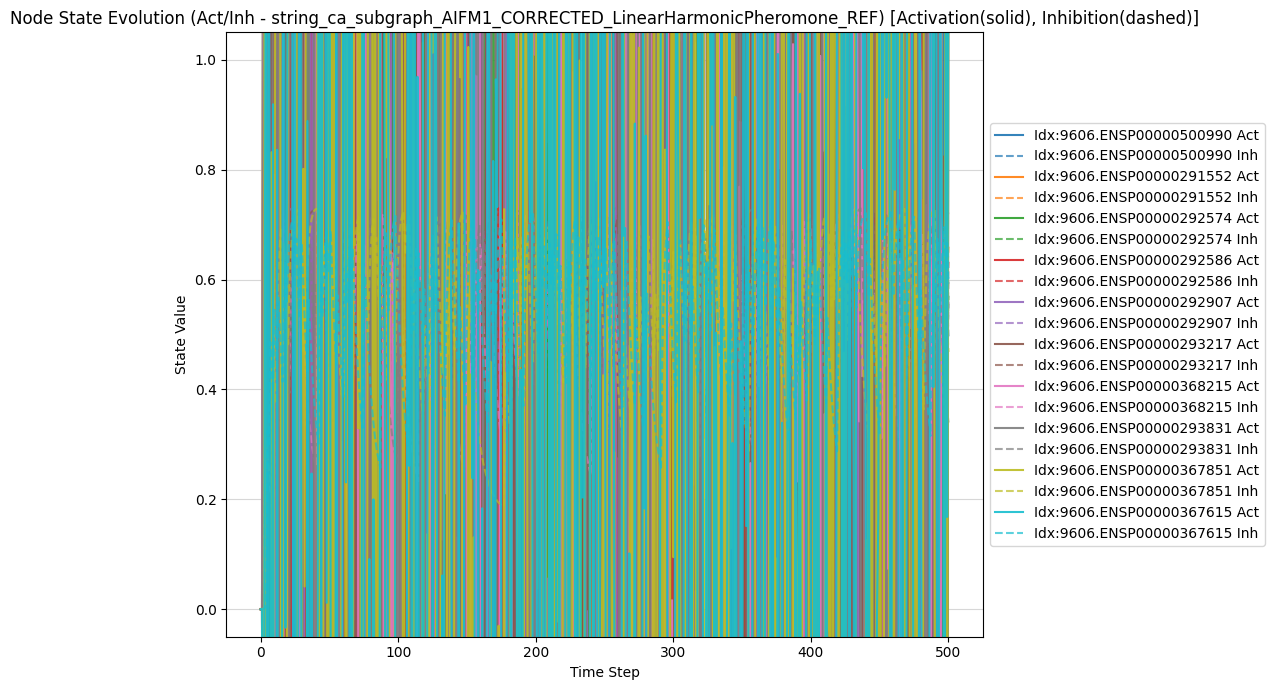


Cell 3: Analysis & Visualization Execution for H+P Reference Run completed.


In [7]:
# Cell 3: Execute Analysis & Visualization (H+P Reference Run)
# Description: Executes the analysis and visualization functions defined in Cell 1.1
#              using the raw simulation results stored locally from the H+P reference run (Cell 2).
#              Loads necessary graph data directly. Saves plots to this run's specific output directory.
# UPDATED: Loads graph data locally for analysis robustness.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
import traceback
from IPython.display import display, Image # For displaying saved images
from tqdm.auto import tqdm # For progress bars
import pickle # For loading graph data
import networkx as nx # For type checking graph

print("\n--- Cell 3: Execute Analysis & Visualization (H+P Reference Run) ---")

# --- Prerequisites Check ---
analysis_exec_error_ref = False
# Check for results variables from Cell 2 of this notebook
if 'run_state_history_ref' not in locals() or not run_state_history_ref:
    print("❌ Analysis Error: 'run_state_history_ref' missing or empty (Run Cell 2).")
    analysis_exec_error_ref = True
# Check for config dict from Cell 1 of this notebook
if 'config_for_ref_run' not in globals():
    print("❌ Analysis Error: Reference config 'config_for_ref_run' missing (Run Cell 1).")
    analysis_exec_error_ref = True
# Check if analysis functions are defined (should be from Cell 1.1)
analysis_funcs_ref = ['reformat_history_for_analysis', 'plot_vector_node_history',
                      'visualize_combined_graph_state', 'calculate_entropy_timeseries',
                      'detect_oscillations_fft', 'calculate_clustering_metric']
missing_funcs_ref = [f for f in analysis_funcs_ref if f not in globals() or not callable(globals()[f])]
if missing_funcs_ref:
    print(f"❌ Analysis Error: Required functions missing: {missing_funcs_ref} (Defined in Cell 1.1?).")
    analysis_exec_error_ref = True

# --- Load Required Graph Data ---
G_analysis = None; pos_analysis = None; node_list_analysis = None; int_to_node_analysis = None
if not analysis_exec_error_ref:
    try:
        setup_dir = os.path.join("simulation_results", "Ablation_Setup_Files")
        print(f"Loading graph data for analysis from: {setup_dir}")
        # Load only what's needed for analysis functions
        graph_path = os.path.join(setup_dir, "graph_G.pkl")
        pos_path = os.path.join(setup_dir, "graph_pos.pkl")
        nodelist_path = os.path.join(setup_dir, "node_list.pkl")
        intnode_path = os.path.join(setup_dir, "int_to_node.pkl")

        if not os.path.exists(graph_path): raise FileNotFoundError("graph_G.pkl missing.")
        with open(graph_path, 'rb') as f: G_analysis = pickle.load(f)
        if not isinstance(G_analysis, nx.Graph): raise TypeError("Loaded graph is not a NetworkX Graph.")
        print("  ✅ Loaded graph_G.pkl")

        if os.path.exists(pos_path): # Position is optional
             with open(pos_path, 'rb') as f: pos_analysis = pickle.load(f)
             if not isinstance(pos_analysis, dict): pos_analysis=None; print("  ⚠️ Loaded pos is not a dict, setting to None.")
             else: print("  ✅ Loaded graph_pos.pkl")
        else: print("  ⚠️ graph_pos.pkl not found.")

        if not os.path.exists(nodelist_path): raise FileNotFoundError("node_list.pkl missing.")
        with open(nodelist_path, 'rb') as f: node_list_analysis = pickle.load(f)
        if not isinstance(node_list_analysis, list): raise TypeError("Loaded node_list is not a list.")
        print("  ✅ Loaded node_list.pkl")

        if not os.path.exists(intnode_path): raise FileNotFoundError("int_to_node.pkl missing.")
        with open(intnode_path, 'rb') as f: int_to_node_analysis = pickle.load(f)
        if not isinstance(int_to_node_analysis, dict): raise TypeError("Loaded int_to_node is not a dict.")
        print("  ✅ Loaded int_to_node.pkl")

    except Exception as e_load_graph:
        print(f"❌ Error loading graph data in Cell 3: {e_load_graph}")
        analysis_exec_error_ref = True


# --- Proceed with Analysis if Prerequisites Met ---
if not analysis_exec_error_ref:
    # Use the specific experiment name for this reference run from Cell 1 config
    exp_name_ref = config_for_ref_run['EXPERIMENT_NAME']
    # Define output dir using base OUTPUT_DIR from Cell 1 config
    output_dir_base = config_for_ref_run.get('OUTPUT_DIR', 'simulation_results')
    exp_output_dir_ref = os.path.join(output_dir_base, exp_name_ref)
    if not os.path.exists(exp_output_dir_ref): os.makedirs(exp_output_dir_ref) # Ensure exists

    # Use locally stored history from Cell 2
    state_history_local = run_state_history_ref
    ref_state_dim_local = 2 # Explicitly 2D for this analysis

    print(f"\nAnalyzing results for experiment: {exp_name_ref}")
    print(f"Using state history with {len(state_history_local)} steps.")

    # --- 1. Reformat History & Basic Plotting ---
    print("\n--- Step 1: Reformatting History & Plotting Timeseries (H+P Ref) ---")
    act_df_local = pd.DataFrame(); inh_df_local = pd.DataFrame() # Initialize
    try:
        reformat_func = globals().get('reformat_history_for_analysis') # Defined in Cell 1.1
        if callable(reformat_func):
            # Use node list loaded in *this cell*
            act_df_local, inh_df_local = reformat_func(state_history_local, node_list_analysis)
            if act_df_local.empty or inh_df_local.empty:
                 warnings.warn("Reformatting yielded empty Act/Inh DataFrames.")
            else:
                 print("  History reformatted successfully.")
                 # Save DFs - redundancy ok
                 try:
                     act_df_local.to_csv(os.path.join(exp_output_dir_ref, "activation_history_analysis.csv")) # Suffix to distinguish
                     inh_df_local.to_csv(os.path.join(exp_output_dir_ref, "inhibition_history_analysis.csv"))
                     print(f"  Saved analysis history CSVs to {exp_output_dir_ref}")
                 except Exception as e_csv: print(f"  Error saving analysis CSVs: {e_csv}")

                 # Plot Timeseries
                 plot_history_func = globals().get('plot_vector_node_history')
                 plot_node_count = config_for_ref_run.get('NODES_TO_PLOT_COUNT', 10)
                 int_to_node_map_local = int_to_node_analysis # Use loaded map

                 if callable(plot_history_func):
                     nodes_to_plot_ids = [];
                     if G_analysis and G_analysis.number_of_nodes() > 0: # Use loaded graph
                         try:
                              final_activations_ref = act_df_local.iloc[-1].dropna()
                              if not final_activations_ref.empty:
                                   sorted_nodes = final_activations_ref.sort_values(ascending=False).index
                                   nodes_to_plot_ids = [n for n in sorted_nodes if n in node_list_analysis][:min(plot_node_count, len(sorted_nodes))] # Check against loaded list
                              else: raise ValueError("Final activation ref empty")
                         except Exception: # Fallback to degree
                              degrees = {node: d for node, d in G_analysis.degree()}
                              sorted_nodes_by_degree = sorted(degrees, key=degrees.get, reverse=True)
                              nodes_to_plot_ids = [node for node in sorted_nodes_by_degree if node in node_list_analysis][:plot_node_count]
                     else: nodes_to_plot_ids = node_list_analysis[:plot_node_count];

                     if nodes_to_plot_ids:
                         print(f"  Plotting timeseries for nodes: {nodes_to_plot_ids}")
                         fig_ts_ref = plot_history_func(act_df_local, inh_df_local, nodes_to_plot_ids, int_to_node_map_local, f"Node State Evolution (Act/Inh - {exp_name_ref})")
                         if fig_ts_ref:
                              ts_plot_path = os.path.join(exp_output_dir_ref, "timeseries_plot_ActInh_Analysis.png") # Unique name
                              try: fig_ts_ref.savefig(ts_plot_path, dpi=100, bbox_inches='tight'); print(f"  Timeseries plot saved to: {ts_plot_path}")
                              except Exception as e_save: print(f"  Error saving timeseries plot: {e_save}")
                              finally: plt.close(fig_ts_ref) # Close figure handle
                     else: print("  No nodes selected for timeseries plot.")
                 else: print("  Plotting function 'plot_vector_node_history' not found.")
        else: print("  Reformatting function 'reformat_history_for_analysis' not found."); analysis_exec_error_ref = True
    except Exception as e: print(f"  Error during reformatting/timeseries plot: {e}"); traceback.print_exc(limit=1); analysis_exec_error_ref = True


    # --- 2. Generate Snapshots ---
    print("\n--- Step 2: Generating Snapshots (H+P Ref) ---")
    if pos_analysis is not None: # Use loaded layout
        try:
            snapshot_func = visualize_combined_graph_state # Defined in Cell 1.1
            snapshot_steps_ref = config_for_ref_run.get('SNAPSHOT_STEPS', [0, len(state_history_local)//2, len(state_history_local)-1])
            snapshot_dir_ref = os.path.join(exp_output_dir_ref, "snapshots_analysis"); os.makedirs(snapshot_dir_ref, exist_ok=True)
            final_step_num_ref = len(state_history_local) - 1
            valid_steps_ref = sorted(list(set([s for s in snapshot_steps_ref if 0 <= s <= final_step_num_ref])))

            if valid_steps_ref:
                 print(f"  Generating snapshots for steps: {valid_steps_ref}")
                 snap_iterator = tqdm(valid_steps_ref, desc="Generating Ref Snapshots", leave=False) if len(valid_steps_ref) > 5 else valid_steps_ref
                 for step_num in snap_iterator:
                     fig_snap = None; fig_snap_temp = None
                     try:
                         with plt.style.context('default'):
                              fig_snap_temp, ax_snap = plt.subplots(figsize=(12, 9))
                              # Use loaded graph and pos
                              fig_snap = snapshot_func(G_analysis, state_history_local[step_num], pos_analysis, step_num, exp_name_ref, ax=ax_snap)
                              if fig_snap:
                                   snapshot_path = os.path.join(snapshot_dir_ref, f"snapshot_step_{step_num:04d}.png")
                                   fig_snap.savefig(snapshot_path, dpi=150, bbox_inches='tight');
                              else:
                                   print(f"    Snapshot function failed for step {step_num}.")
                     except Exception as e_snap:
                         print(f"    Error generating snapshot step {step_num}: {e_snap}")
                     finally: # Ensure figure is closed
                          if fig_snap is not None and plt.fignum_exists(fig_snap.number): plt.close(fig_snap)
                          elif fig_snap_temp is not None and plt.fignum_exists(fig_snap_temp.number): plt.close(fig_snap_temp)
                 print(f"  Snapshots saved to: {snapshot_dir_ref}")
            else: print("  No valid snapshot steps to generate.")
        except Exception as e: print(f"  Error during snapshot generation setup: {e}"); traceback.print_exc(limit=1)
    else: print("  Skipping snapshots because layout (pos_analysis) is missing or failed to load.")


    # --- 3. Display Final Metrics (Calculated in Cell 2) & Analysis Plots ---
    print("\n--- Step 3: Displaying Final Metrics & Analysis Plots (H+P Ref) ---")
    if 'run_metrics_ref' in locals() and isinstance(run_metrics_ref, dict):
        print("  Metrics calculated during run_experiment_no_analysis (from Cell 2):")
        print(f"    Final Variance (Act): {run_metrics_ref.get('final_variance_activation', np.nan):.6f}")
        print(f"    Final Entropy (Act): {run_metrics_ref.get('final_entropy_activation', np.nan):.4f}")
        print(f"    Final Entropy (Inh): {run_metrics_ref.get('final_entropy_inhibition', np.nan):.4f}")
        clust_key = f"final_clustering_fraction_{ref_state_dim_local}d"
        print(f"    Final Clustering ({ref_state_dim_local}D): {run_metrics_ref.get(clust_key, np.nan):.4f}")
        avg_ph_key = f"final_average_pheromones"
        print(f"    Avg Final Pheromone: {run_metrics_ref.get(avg_ph_key, np.nan):.6f}")

        # Display plots saved by *this* analysis cell
        print("\n  Displaying plots generated by this analysis cell (if generated):")
        plot_files_to_display_ref = [
            "timeseries_plot_ActInh_Analysis.png", # Plot from Step 1
            # Add paths for entropy/clustering plots if they are generated here now
            # "entropy_timeseries_ActInh_Analysis.png", # If generated here
            # f"clustering_timeseries_{ref_state_dim_local}D_Analysis.png" # If generated here
        ]
        for fname in plot_files_to_display_ref:
            fpath = os.path.join(exp_output_dir_ref, fname) # Look in the correct experiment output dir
            if os.path.exists(fpath):
                print(f"\n    Displaying {fname}:")
                try: display(Image(filename=fpath))
                except Exception as e_disp: print(f"      Could not display image: {e_disp}")
            else: print(f"    Analysis plot not found: {fname}")
    else:
        print("  Metrics dictionary ('run_metrics_ref') not found or invalid (Run Cell 2).")

else: # analysis_exec_error_ref was True
    print("\nAnalysis execution skipped due to missing prerequisites.")

print("\nCell 3: Analysis & Visualization Execution for H+P Reference Run completed.")

In [8]:
# Cell 4: Identify and Save "Red Region" Nodes (H+P Reference Run)
# Description: Calculates Activation - Inhibition for the final step of the H+P reference run,
#              identifies nodes exceeding the threshold, and saves their STRING IDs
#              to `simulation_results/aifm1_red_ids.txt` (and an analysis-specific file).
#              Uses analysis DataFrames created locally in Cell 3.

import numpy as np
import pandas as pd
import os
import warnings
import traceback

print("\n--- Cell 4: Identifying 'Red Region' Nodes (H+P Reference Run) ---")

# --- Prerequisites ---
red_region_error_ref = False
# Check for the specific DFs created in Cell 3 of this notebook
if 'act_df_local' not in locals() or act_df_local is None or act_df_local.empty: print("❌ Cannot identify Red Region: 'act_df_local' missing or empty (Run Cell 3)."); red_region_error_ref = True
if 'inh_df_local' not in locals() or inh_df_local is None or inh_df_local.empty: print("❌ Cannot identify Red Region: 'inh_df_local' missing or empty (Run Cell 3)."); red_region_error_ref = True
# Check for threshold defined in Cell 1 of this notebook
if 'REF_RED_REGION_THRESHOLD' not in globals(): print("❌ Cannot identify Red Region: REF_RED_REGION_THRESHOLD not set (Cell 1)."); red_region_error_ref = True
# Check for output directories defined/loaded in Cell 1
if 'OUTPUT_DIR' not in globals(): print("❌ Cannot save target file: Base OUTPUT_DIR missing."); red_region_error_ref = True
if 'ANALYSIS_DIR' not in globals(): print("❌ Cannot save analysis file: Base ANALYSIS_DIR missing."); red_region_error_ref = True
if 'config_for_ref_run' not in globals(): print("❌ Cannot determine output subdirs: Reference config missing."); red_region_error_ref = True

# --- Initialize ---
red_region_nodes_ref = [] # Store nodes identified from this reference run
red_region_filepath_ref_analysis = None # Analysis-specific output path
target_ids_filepath_ref = None # Path for the aifm1_red_ids.txt file

if not red_region_error_ref:
    threshold_val = REF_RED_REGION_THRESHOLD
    exp_name_ref = config_for_ref_run['EXPERIMENT_NAME']
    # Define output paths using loaded base directories and specific experiment name
    output_dir_analysis_ref = os.path.join(ANALYSIS_DIR, f"Analysis_{exp_name_ref}") # Specific analysis output
    output_dir_sim_base = OUTPUT_DIR # Base simulation results dir for aifm1_red_ids.txt

    os.makedirs(output_dir_analysis_ref, exist_ok=True) # Ensure analysis output dir exists

    print(f"Calculating Red Region for run '{exp_name_ref}': Final_Activation - Final_Inhibition > {threshold_val}")
    try:
        # Use the local DataFrames created in Cell 3
        if act_df_local.empty or inh_df_local.empty:
             raise ValueError("Act/Inh DataFrames for Red Region calculation are empty.")

        final_step_index_ref = act_df_local.index.max()
        final_act_ref = act_df_local.loc[final_step_index_ref]
        final_inh_ref = inh_df_local.loc[final_step_index_ref]

        state_diff_ref = (final_act_ref - final_inh_ref).dropna()
        total_nodes_final_ref = len(state_diff_ref)

        if total_nodes_final_ref > 0:
            red_region_mask_ref = state_diff_ref > threshold_val
            # Get node IDs (which are the index of the series)
            red_region_nodes_local_ref = state_diff_ref[red_region_mask_ref].index.tolist()
            num_red_nodes_ref = len(red_region_nodes_local_ref)

            red_region_nodes_ref = red_region_nodes_local_ref # Store locally if needed

            print(f"  Found {num_red_nodes_ref:,} nodes in the Red Region (out of {total_nodes_final_ref:,} valid nodes at step {final_step_index_ref}).")

            # --- Save STRING IDs to BOTH Files ---
            if num_red_nodes_ref > 0:
                # 1. Save to analysis-specific folder
                analysis_filename_ref = os.path.join(output_dir_analysis_ref, f"red_region_nodes_thresh{threshold_val}.txt")
                try:
                    with open(analysis_filename_ref, 'w') as f:
                        # Ensure writing strings
                        for node_id in red_region_nodes_ref: f.write(f"{str(node_id)}\n")
                    print(f"  ✅ Saved {num_red_nodes_ref} analysis Red Region IDs to: {analysis_filename_ref}")
                    red_region_filepath_ref_analysis = analysis_filename_ref # Store path if needed
                except Exception as e: print(f"  ❌ Error saving analysis Red Region IDs: {e}")

                # 2. Save specifically named file to main simulation_results directory
                target_filename_ref = "aifm1_red_ids.txt" # Specific name needed
                target_ids_filepath_ref = os.path.join(output_dir_sim_base, target_filename_ref)
                try:
                    with open(target_ids_filepath_ref, 'w') as f:
                        # Ensure writing strings
                        for node_id in red_region_nodes_ref: f.write(f"{str(node_id)}\n")
                    print(f"  ✅ Saved {num_red_nodes_ref} IDs to target file: {target_ids_filepath_ref}")
                except Exception as e: print(f"  ❌ Error saving target '{target_filename_ref}': {e}")

            else: print("  Skipping saving files (no nodes found in Red Region).")
        else:
             print("⚠️ Cannot identify Red Region: No nodes have valid final states in reference run.")

    except KeyError as ke:
         print(f"❌ KeyError accessing final step data (Index: {final_step_index_ref}). History files might be corrupted or have unexpected format.")
         red_region_error_ref = True
    except Exception as e:
         print(f"❌ Error during Red Region identification: {e}")
         traceback.print_exc()
         red_region_error_ref = True

else:
    print("Red Region identification skipped due to missing prerequisites.")

# Store path globally for potential use by ablation_07 (optional)
# globals()['target_ids_filepath_ref'] = target_ids_filepath_ref

print("\nCell 4: Red Region Identification and File Generation complete.")


--- Cell 4: Identifying 'Red Region' Nodes (H+P Reference Run) ---
Calculating Red Region for run 'string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF': Final_Activation - Final_Inhibition > 0.5
  Found 707 nodes in the Red Region (out of 2,334 valid nodes at step 500).
  ✅ Saved 707 analysis Red Region IDs to: biological_analysis_results/Analysis_string_ca_subgraph_AIFM1_CORRECTED_LinearHarmonicPheromone_REF/red_region_nodes_thresh0.5.txt
  ✅ Saved 707 IDs to target file: simulation_results/aifm1_red_ids.txt

Cell 4: Red Region Identification and File Generation complete.
